# ALeRCE supernova starter notebook

```Author: Francisco Förster, Last updated: 20240506```

ALeRCE starter notebook for supernova science using the new alerce client, API, and a direct database connection. You will also use the ALeRCE DELIGHT tool to automatically identify host galaxies in SNe.

For more information about the ALeRCE broker, please visit http://alerce.science/, or read our publications:
* The Automatic Learning for the Rapid Classification of Events (ALeRCE) Alert Broker, [Förster et al. 2021, AJ, 161, 242](https://arxiv.org/abs/2008.03303)
* Alert Classification for the ALeRCE Broker System: The Real-time Stamp Classifier, [Carrasco-Davis et al. 2021, AJ, 162, 231](https://arxiv.org/abs/2008.03309)
* Alert Classification for the ALeRCE Broker System: The Light Curve Classifier, [Sánchez-Sáez et al. 2021, AJ, 161, 141](https://arxiv.org/abs/2008.03311)

Note that this notebook uses the latest ALeRCE client and API, which can be installed with `pip install alerce`

*It is highly recommended that you try this notebook in Google Colab using the following [link](https://colab.research.google.com/github/alercebroker/usecases/blob/master/notebooks/ALeRCE_SN_Starter.ipynb).*
This will avoid you from having to sort out library installation problems and focus on the contents of the tutorial. You can try installing the dependencies later in your own system. However, note that in this notebook we use ipyaladin, which does not currently work in Google Colab.

# Introduction

In this notebook we will query data from a single supernova in order to plot its apparent and absolute magnitude light curve, applying Milky Way dust attenuation corrections as well. We will also see its image stamp, and visualize the host galaxy to make sure the redshift used is correct. We will identify the host galaxy using the ALeRCE DELIGHT tool (https://pypi.org/project/astro-delight/) and then use NED to get the spectroscopic redshift if available.

Then, we will query many supernova using the ALeRCE client, showing the distribution of peak magnitudes and dust attenuations.

Finally, we will repeat this calculation for a much larger sample size connecting directly to the ALeRCE database, doing more advanced queries like extracting features, probabilities, and light curves for a large set of objects.

# Requirements

Basic requirements

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Astropy

In [2]:
import astropy.units as u
from astropy import coordinates
from astropy.time import Time
from astropy.table import Table, Column
from astropy.coordinates import Distance
from astropy.cosmology import WMAP7

Install and import pyaladin https://github.com/cds-astro/ipyaladin

In [3]:
# This won't work in Colab
# you may need to restart the notebook after running the following lines
#!pip install ipyaladin
#!jupyter nbextension enable --py widgetsnbextension
#!jupyter nbextension enable --py --sys-prefix ipyaladin

In [4]:
import ipyaladin as ipyal # see installation instructions here: https://github.com/cds-astro/ipyaladin

Astroquery https://astroquery.readthedocs.io/en/latest/

In [5]:
#!pip install astroquery
from astroquery.ned import Ned
from astroquery.irsa_dust import IrsaDust

Visualization

In [6]:
from IPython.display import HTML
from ipywidgets import Layout, Box, widgets

SQL queries using SQLalchemy

In [1]:
import sqlalchemy as sa

The requests library

In [8]:
import requests

The ALeRCE client <a class="anchor" id="client"></a>

In [9]:
#!pip install alerce

In [10]:
from alerce.core import Alerce
client = Alerce()

The ALeRCE DELIGHT client (https://pypi.org/project/astro-delight/)

WARNING: this will try to install tensorflow if you haven't installed it (`pip install tensorflow`). Some people report that their python distribution has problems after trying to install tensorflow.

In [11]:
#!pip install astro-delight

In [12]:
from delight.delight import *

Color blind friendly colors

In [13]:
# color blind friendly green and red 
colors = {1: '#56E03A', 2: '#D42F4B'} 

# Querying and plotting individual objects using the ALeRCE client and DELIGHT

In this section we will focus on a single supernova and will extract its basic properties, its light curve and the host.

## Simple functions to plot light curves

We will create a simple function that plots the light curve given an object id (`oid`), a dataframe with detections and a dataframe with non detections. We will first define manually the `oid` that we want to explore (we will select a SN Ia with a known host redshift in NED for test purposes, we will later do queries for a collection of SNe).

In [14]:
def plotLC(oid, SN_det, SN_nondet):
    
    fig, ax = plt.subplots(figsize = (14, 7))
    labels = {1: 'g', 2: 'r'}
    markers = {1: 'o', 2: 's'}
    sizes = {1: 30, 2: 60}
    
    # loop the passbands
    for fid in [1, 2]:
        
        # plot detections if available
        mask = SN_det.fid == fid
        if np.sum(mask) > 0:
            # note that the detections index is candid and that we are plotting the psf corrected magnitudes
            ax.errorbar(SN_det[mask].mjd, SN_det[mask].magpsf, 
                yerr = SN_det[mask].sigmapsf, c=colors[fid], label=labels[fid], marker=markers[fid])
        
        # plot non detections if available
        mask = (SN_nondet.fid == fid) & (SN_nondet.diffmaglim > -900)
        if np.sum(mask) > 0:     
            # non detections index is mjd
            ax.scatter(SN_nondet[mask].mjd, SN_nondet[mask].diffmaglim, c=colors[fid], alpha = 0.5,
                marker='v', label="lim.mag. %s" % labels[fid], s=sizes[fid])
            
    ax.set_title(oid, fontsize=20)
    ax.set_xlabel("MJD", fontsize=20)
    ax.set_ylabel("Apparent magnitude", fontsize=20)
    ax.legend()
    ax.set_ylim(ax.get_ylim()[::-1])

Then, we will create a function that only gets the light curve (LC) data and plots it if required, the results are then returned to the user as a dictionary. Note that we use the client to query the detections and non detections and that we return the results in pandas format (default is votable).

In [15]:
def getSNdata(oid, doLC=False):

    results = {"oid": oid}
        
    # query detections
    SN_det = client.query_detections(oid, format='pandas')
    SN_det = SN_det.sort_values("mjd")
    results["lc_det"] = SN_det
        
    # query non detections
    SN_nondet = client.query_non_detections(oid, format='pandas')
    SN_nondet = SN_nondet.sort_values("mjd")
    results["lc_nondet"] = SN_nondet
    
    # plot the LC
    if doLC:
        plotLC(oid, SN_det, SN_nondet)
        
    # return data
    return results

And now we can show the object's light curve given the unique object identifier

In [16]:
seloid = "ZTF20acbovrt" 

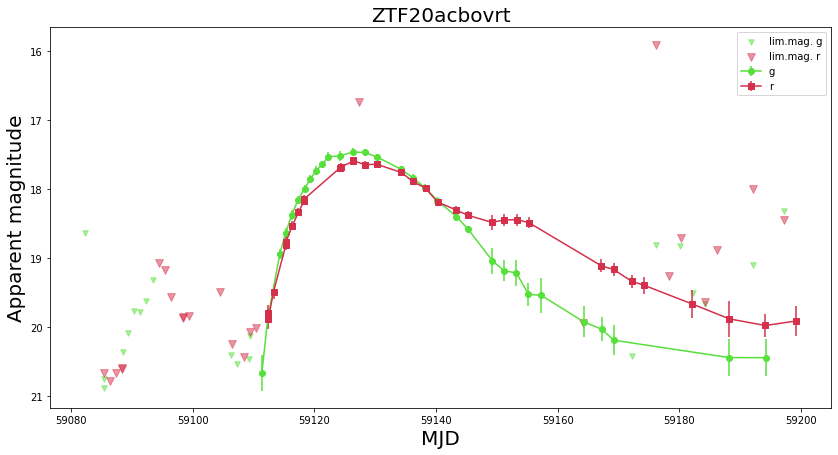

In [17]:
results = getSNdata(seloid, doLC=True)

You can see the detections and non detections in g and r bands. The SN shows a secondary r band bump, which is characteristic of normal SNe Ia.

## Using DELIGHT to predict the host position

Now we will use the [DELIGHT](https://ui.adsabs.harvard.edu/abs/2022AJ....164..195F/abstract) library to estimate the position of the host. This is important to query the correct position of the sky to extract sources near the center of the host and with this information estimate its redshift and then the distance to the supernova.

In [18]:
obj = client.query_object(seloid)

In [19]:
def gethost(name, ra, dec, doplot=False):
    dclient = Delight("./", [name], [ra], [dec])
    dclient.download()
    dclient.get_pix_coords()
    dclient.compute_multiresolution(nlevels=5, domask=False, doobject=True, doplot=False)
    dclient.load_model()
    dclient.preprocess()
    dclient.predict()
    if doplot:
        dclient.plot_host(name)
    display(dclient.df)
    return dclient.df.loc[name].ra_delight, dclient.df.loc[name].dec_delight

stack_r_ra343.298556_dec11.113533_arcsec120_skycell1586.076.fits
stack_r_ra217.066348_dec-1.982149_arcsec120_skycell1286.052.fits
stack_r_ra208.777244_dec54.304888_arcsec120_skycell2381.055.fits
stack_r_ra231.582920_dec50.680863_arcsec120_skycell2328.068.fits
stack_r_ra359.866189_dec17.865197_arcsec120_skycell1678.045.fits
stack_r_ra14.724656_dec29.943803_arcsec120_skycell1933.042.fits
stack_r_ra260.101637_dec55.214638_arcsec120_skycell2389.087.fits
stack_r_ra200.261022_dec20.098752_arcsec120_skycell1811.007.fits
stack_r_ra89.469710_dec-21.552352_arcsec120_skycell0817.066.fits
stack_r_ra24.330464_dec4.801942_arcsec120_skycell1418.024.fits
stack_r_ra265.492915_dec47.104484_arcsec120_skycell2272.073.fits
stack_r_ra30.922588_dec52.150494_arcsec120_skycell2354.007.fits
stack_r_ra359.636873_dec-1.145367_arcsec120_skycell1232.075.fits
stack_r_ra132.410433_dec54.269198_arcsec120_skycell2369.052.fits
stack_r_ra244.603292_dec38.133336_arcsec120_skycell2134.055.fits
stack_r_ra350.614460_dec6.912

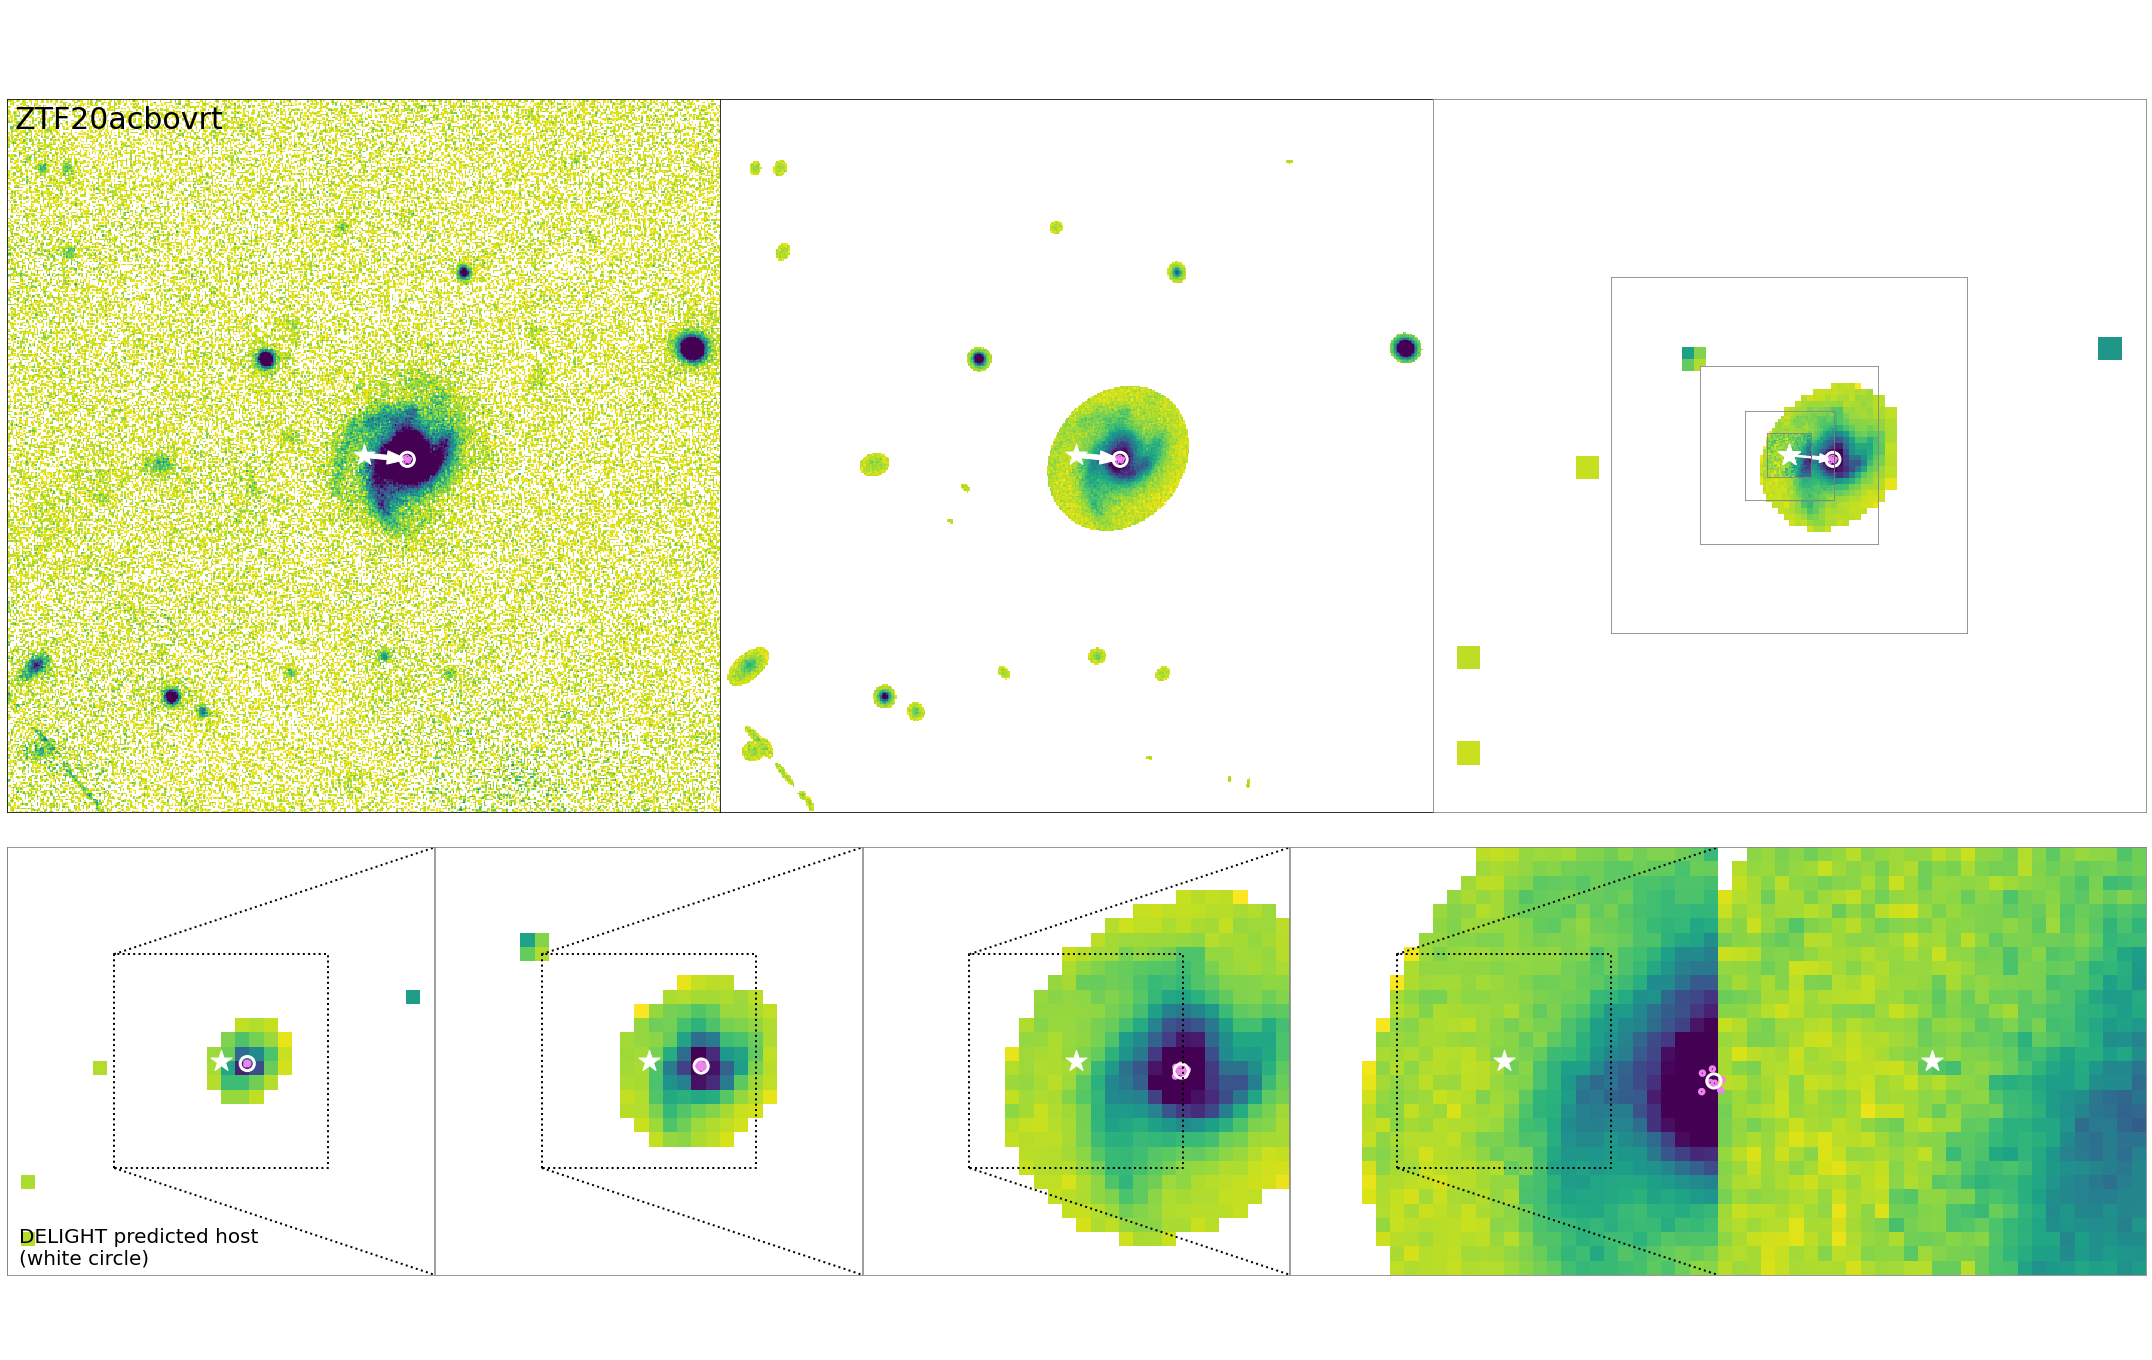

ra        dec      dist  \
oid                                             
ZTF20acbovrt  359.866189  17.865197  0.000475   

                                                       filename  \
oid                                                               
ZTF20acbovrt  stack_r_ra359.866189_dec17.865197_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF20acbovrt  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF20acbovrt  <SkyCoord (ICRS): (ra, dec) in deg\n    (359.8...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF20acbovrt  240.3620525602082  240.52489359662763   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF20acbovrt  [[29.52071189880371, -3.108792304992676], [28....   29.42709   

             dy_delight  std_delight  \
oid                                    
ZTF20acbovrt  -2.787552     1.560387   

                                       host_coords_delight_pred  \
oid                                                               
ZTF20acbovrt  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF20acbovrt  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   359.86405   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF20acbovrt    17.865004  359.864181  17.865032  

[1 rows x 25 columns]

In [20]:
ra_host, dec_host = gethost(seloid, obj["meanra"], obj["meandec"], doplot=True)

You can see that DELIGHT was able to correctly predict the position of the host (white circle). The library uses a multi resolution representation of the host image and then a convolutional neural network to predict eight position vectors after doing rotations and flips. The average of these eight vectors is used as the prediction. 

## Advanced plotting functions including dust and distance attenuation corrections  <a class="anchor" id="advancedfunctions"></a>

Now we will modify our previous function to receive a dictionary with attenuations due to Galactic extinction, as well as the redshift. This will allow us to get absolute magnitudes (assuming no K-corrections) in restframe days. Note that we use astroquery Distance and WMAP7 objects, as well as mag units.

In [21]:
def plotLC(oid, SN_det, SN_nondet, A=None, redshift=None):
    
    fig, ax = plt.subplots(figsize = (14, 7))
    labels = {1: 'g', 2: 'r'}
    markers = {1: 'o', 2: 's'}
    sizes = {1: 30, 2: 60}
    
    # distmod: distance modulus, reftime: reference time
    if redshift is not None:
        distmod = float(Distance(z=redshift, cosmology=WMAP7).distmod / u.mag)
        print(f"Redshift: {redshift}, Distance modulus: {distmod}")
        reftime = SN_det.mjd.min() # use the maximum as reference
    else:
        distmod = 0
        reftime = 0
        redshift = 0
        
    # loop the passbands
    for fid in [1, 2]:
        
        # galactic extinction in the given band
        if A is not None:
            A_fid = A[labels[fid]]
        else:
            A_fid = 0

        # plot detections if available
        mask = SN_det.fid == fid
        if np.sum(mask) > 0:
            
            # change time to restframe days if redshift is not zero
            times = (SN_det[mask].mjd - reftime) / (1. + redshift)
            
            # note that the detections index is candid and that we are plotting the psf corrected magnitudes
            if A_fid != 0:
                # plot attenuated light curve with small alpha
                ax.errorbar(times, SN_det[mask].magpsf - distmod, 
                    yerr=SN_det[mask].sigmapsf, c=colors[fid], marker=markers[fid], label=labels[fid], alpha=0.1)
                # show dust and distance attenuation corrected light curve
                ax.errorbar(times, SN_det[mask].magpsf - A_fid - distmod, 
                    yerr=SN_det[mask].sigmapsf, c=colors[fid], marker=markers[fid], label="%s (ext. corr.)" % labels[fid])
            else:
                # correct only for redshift
                ax.errorbar(times, SN_det[mask].magpsf - distmod, 
                    yerr=SN_det[mask].sigmapsf, c=colors[fid], marker=markers[fid], label=labels[fid])
        
        # plot non detections if available (and correct for dust and distance attenuation)
        mask = (SN_nondet.fid == fid) & (SN_nondet.diffmaglim > -900)
        if np.sum(mask) > 0:     
            times = (SN_nondet[mask].mjd - reftime) / (1. + redshift)
            # non detections index is mjd
            ax.scatter(times, SN_nondet[mask].diffmaglim - A_fid - distmod, c = colors[fid], alpha = 0.5,
                marker='v', label="lim.mag. %s" % labels[fid], s=sizes[fid])
            
    # labels
    if A is not None and redshift != 0:
        ax.set_title("%s ($A_g=%.3f, A_r=%.3f$, z=%.4f)" % (oid, A["g"], A["r"], redshift), fontsize=20)
    elif redshift != 0:
        ax.set_title("%s (z=%.4f)" % (oid, redshift), fontsize=20)
    elif A is not None:
        ax.set_title("%s ($A_g=%.3f, A_r=%.3f$)" % (oid, A["g"], A["r"]), fontsize=20)
    else:
        ax.set_title(oid, fontsize=20)
        
    if redshift == 0:
        ax.set_xlabel("MJD", fontsize=20)
        ax.set_ylabel("Apparent magnitude", fontsize=20)
    else:
        ax.set_xlabel("Restframe time [days]", fontsize=20)
        ax.set_ylabel("Absolute magnitude (no K-corr.)", fontsize=20)
    ax.legend()
    ax.set_ylim(ax.get_ylim()[::-1])

We will also modify the getSNdata function to get all the necessary information given the object id (`oid`). It now does the following:
 - display a link to the ALeRCE explorer page for this SN
 - get the basic SN statistics, this includes the position in the sky (using the ALeRCE client)
 - get the detections and non detections (using the ALeRCE client)
 - get the Milky Way dust attenuation at the given position in the sky (using astroquery IrsaDust)
 - plot the apparent magnitude LC corrected for dust attenuation (using the previously defined function)
 - use DELIGHT to guess the position of the host galaxy
 - query NED for galaxies with known redshifts (using astroquery Ned), using the position predicted by DELIGHT
 - plot the absolute magnitude LC correction for Milky Way dust and distance attenuation, in restframe time and ignoring k-corrections (using the previously defined plotLC function)
 - plot the first image stamps associated to this SN (using the ALeRCE client)

In [22]:
def getSNdata(oid, doLC=False, doext=False, dostamp=False, doDELIGHT=False, doNED=False, doredshift=False):

    results = {"oid": oid}
    
    # show link
    display(HTML("<a href='http://alerce.online/object/%s' target=\"_blank\"> %s <a>" % (oid, oid)))

    # query basic stats
    print("Querying basic stats...")
    SN_stats = client.query_object(oid, format='pandas')
    results["stats"] = SN_stats
    
    # query detections
    print("Querying detections...")
    SN_det = client.query_detections(oid, format='pandas')
    SN_det = SN_det.sort_values("mjd")
    results["lc_det"] = SN_det
        
    # query non detections
    print("Querying non detections...")
    SN_nondet = client.query_non_detections(oid, format='pandas')
    SN_nondet = SN_nondet.sort_values("mjd")
    results["lc_nondet"] = SN_nondet
    
    # object coordinates
    co = coordinates.SkyCoord(ra=float(SN_stats.meanra), dec=float(SN_stats.meandec), unit=(u.deg, u.deg), frame='fk5')
    
    # get galactic extinction
    if doext:
        print("Querying Galactic extinction...")
        # Galactic extinction (use SFD = D.J. Schlegel, D.P. Finkbeiner, & M. Davis (1998, ApJ, 500, 525))
        table = IrsaDust.get_extinction_table(co)
        A = {"g": float(table[table["Filter_name"] == "SDSS g"]["A_SFD"]), "r": float(table[table["Filter_name"] == "SDSS r"]["A_SFD"])}
        results["attenuation"] = A
    else:
        A = {"g": 0, "r": 0}

    # plot the LC
    if doLC:
        print("Plot the apparent magnitude light curve...")
        if doext:
            plotLC(oid, SN_det, SN_nondet, A)
        else:
            plotLC(oid, SN_det, SN_nondet)
            
    # use DELIGHT to predict the host position
    if doDELIGHT:
        print("Using DELIGHT to estimate the host position...")
        delight_host_ra, delight_host_dec = gethost(oid, float(SN_stats.meanra), float(SN_stats.meandec), doplot=True)
        co = coordinates.SkyCoord(ra=delight_host_ra, dec=delight_host_dec, unit=(u.deg, u.deg), frame='fk5')

    # find NED galaxies
    if doNED:
        print("Using Ned to query the host position...")
        Ned_table = Ned.query_region(co, radius=0.005 * u.deg, equinox='J2000.0')
        display(Ned_table)
        results["ned_table"] = Ned_table
        
        # save closest redshift if any
        df_ned = Ned_table.to_pandas()
        mask=df_ned.Redshift.notna()
        if mask.sum() > 0:
            results["redshift"] = df_ned.loc[df_ned.loc[mask].Separation.idxmin()].Redshift
            print("Redshift found! %s" % results["redshift"])
        else:
            print("No redshift could be found, cannot plot the absolute magnitudes.")
            
    # plot absolute value (without K-corrections)
    if doredshift:

        if type(doredshift) == float and doredshift > 0:
            results["redshift"] = doredshift
        if "redshift" in results.keys():
            print("Plotting the absolute magnitude light curve...")
            if doext:
                plotLC(oid, SN_det, SN_nondet, A, results["redshift"])
            else:
                plotLC(oid, SN_det, SN_nondet, results["redshift"])            
    
        
    # show the first image stamp
    if dostamp:
        candid = results["lc_det"].loc[results["lc_det"].has_stamp].candid.min()
        stamps = client.get_stamps(oid, candid)
        science, ref, difference = stamps[0].data, stamps[1].data, stamps[2].data
        fig, ax = plt.subplots(ncols=3, figsize=(12, 6))
        for idx, im in enumerate([np.log(science), np.log(ref), difference]):
            ax[idx].imshow(im, cmap='viridis') # Log scale for visualization
            ax[idx].axes.get_xaxis().set_visible(False)
            ax[idx].axes.get_yaxis().set_visible(False)
        ax[0].set_title("oid: %s, candid: %s (science, reference and difference)" % (oid, candid), loc='left', fontsize=20)
        fig.subplots_adjust(wspace = 0, hspace = 0)
        
    # return data
    return results

Now we test these functions with the same SN as before. We selected a SN with a known spectrocopic redshift, but this is usually not the case.

Querying basic stats...
Querying detections...
Querying non detections...
Querying Galactic extinction...
Plot the apparent magnitude light curve...
Using DELIGHT to estimate the host position...
stack_r_ra343.298556_dec11.113533_arcsec120_skycell1586.076.fits
stack_r_ra217.066348_dec-1.982149_arcsec120_skycell1286.052.fits
stack_r_ra208.777244_dec54.304888_arcsec120_skycell2381.055.fits
stack_r_ra231.582920_dec50.680863_arcsec120_skycell2328.068.fits
stack_r_ra359.866189_dec17.865197_arcsec120_skycell1678.045.fits
stack_r_ra14.724656_dec29.943803_arcsec120_skycell1933.042.fits
stack_r_ra260.101637_dec55.214638_arcsec120_skycell2389.087.fits
stack_r_ra200.261022_dec20.098752_arcsec120_skycell1811.007.fits
stack_r_ra89.469710_dec-21.552352_arcsec120_skycell0817.066.fits
stack_r_ra24.330464_dec4.801942_arcsec120_skycell1418.024.fits
stack_r_ra265.492915_dec47.104484_arcsec120_skycell2272.073.fits
stack_r_ra30.922588_dec52.150494_arcsec120_skycell2354.007.fits
stack_r_ra359.636873_dec-1.1

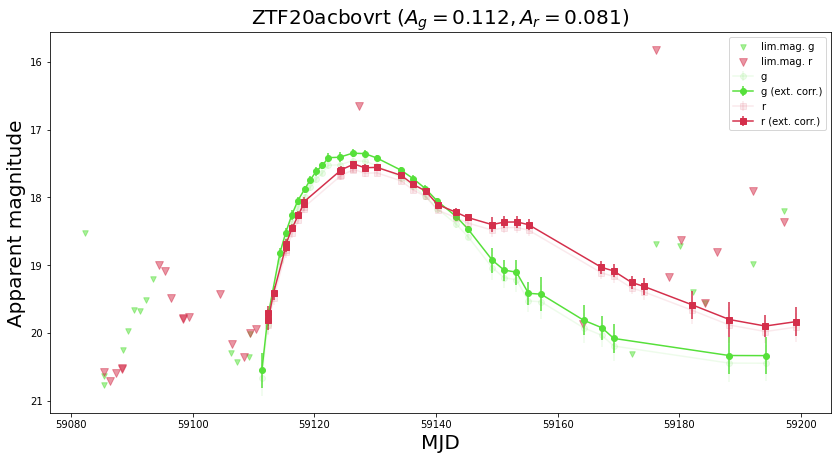

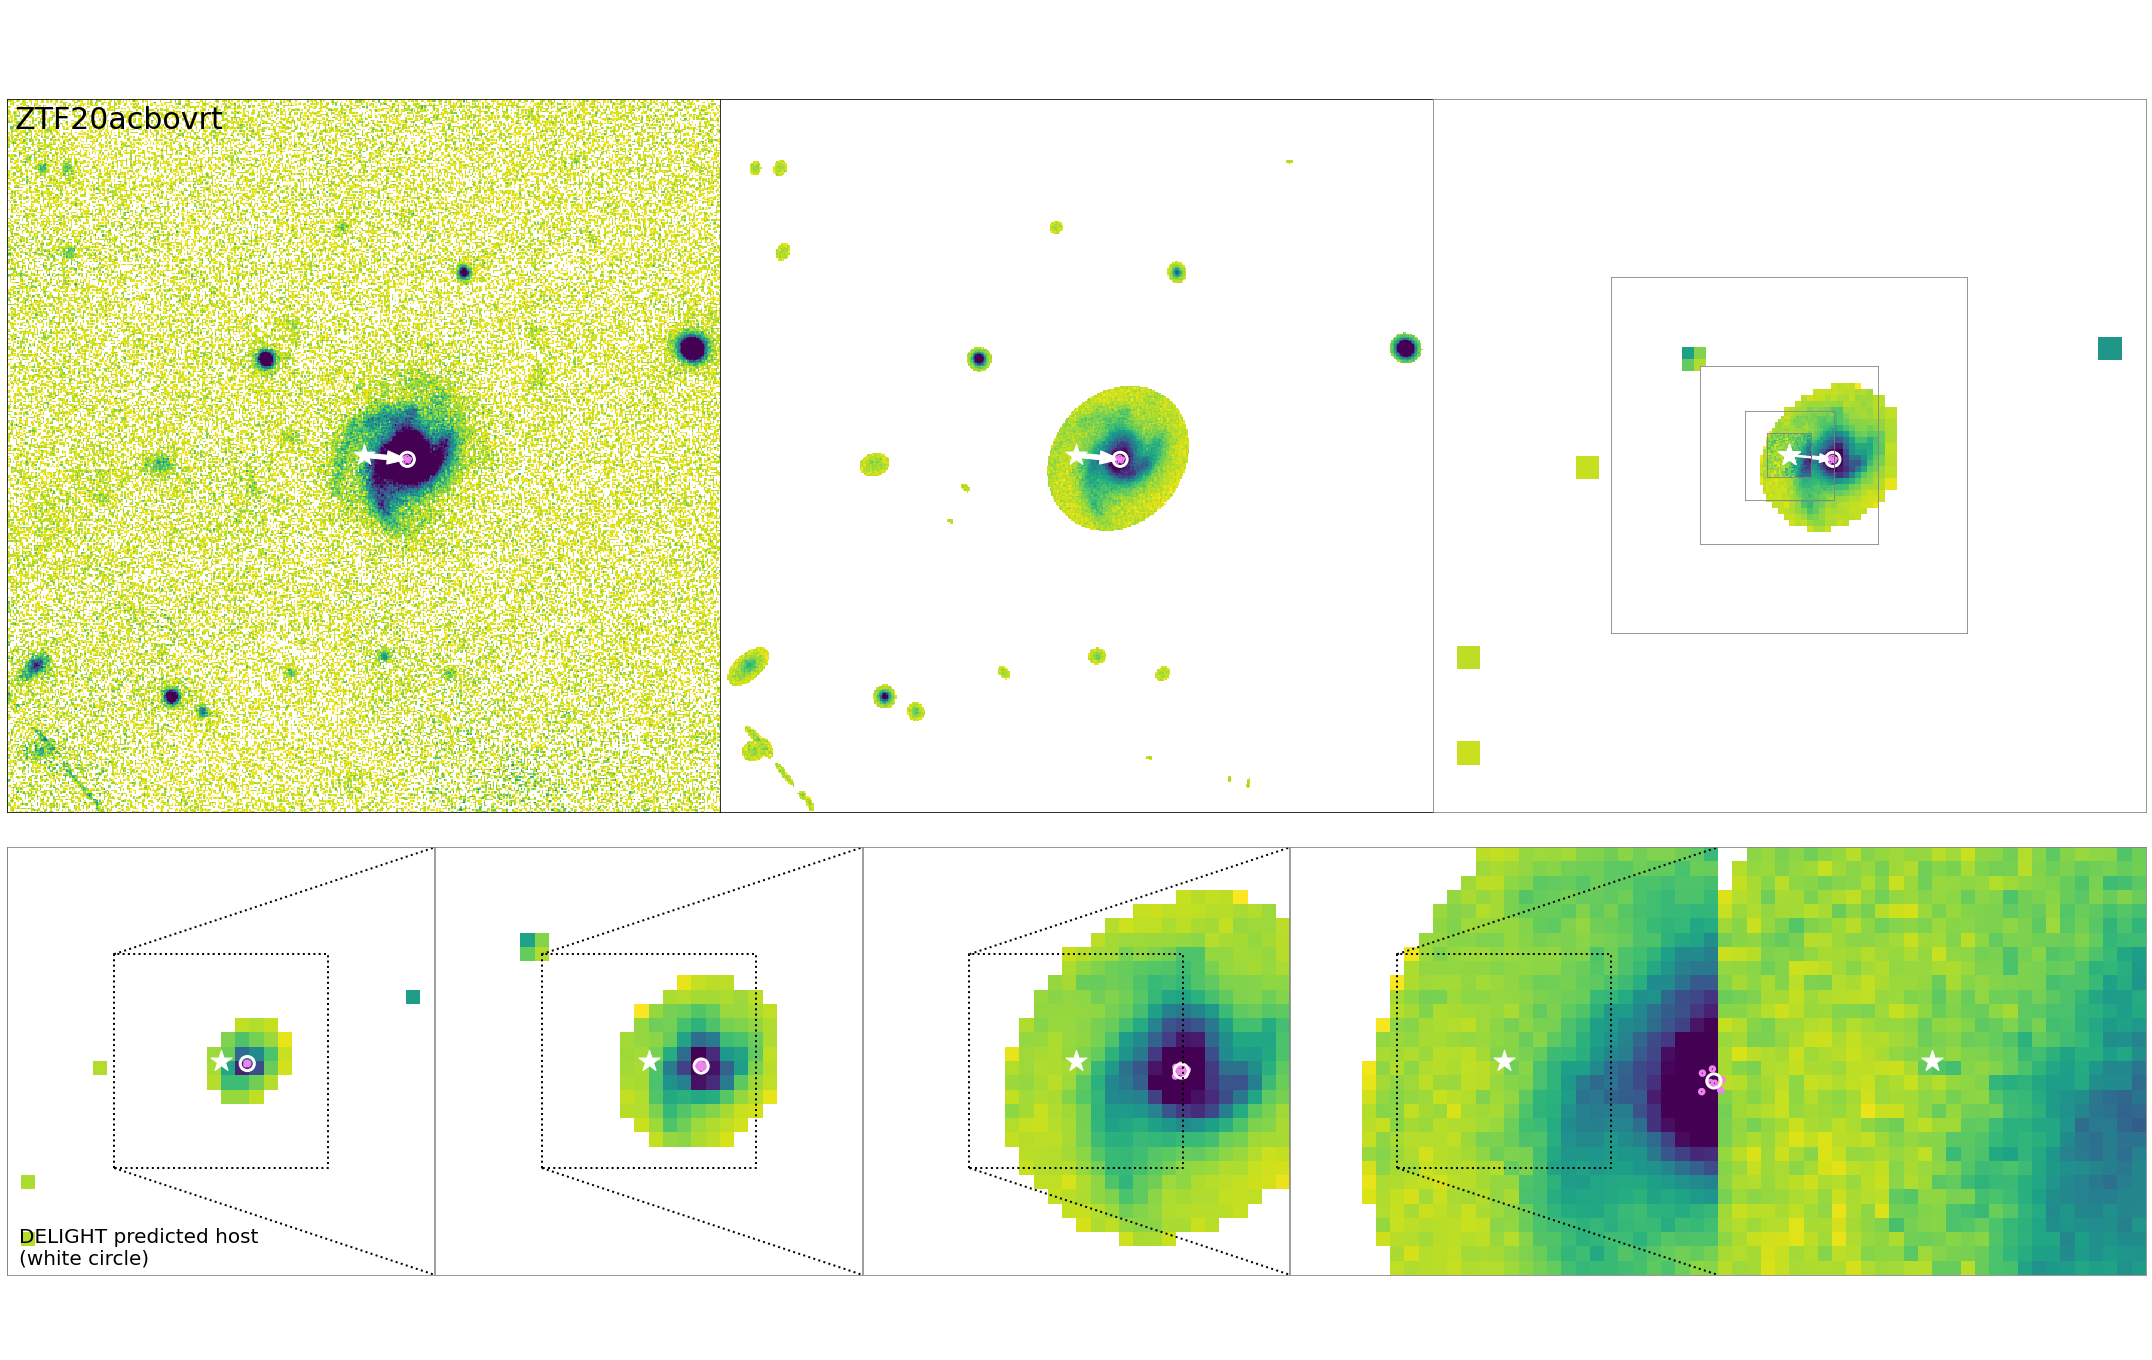

ra        dec      dist  \
oid                                             
ZTF20acbovrt  359.866189  17.865197  0.000475   

                                                       filename  \
oid                                                               
ZTF20acbovrt  stack_r_ra359.866189_dec17.865197_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF20acbovrt  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF20acbovrt  <SkyCoord (ICRS): (ra, dec) in deg\n    (359.8...   

                            xSN                 ySN  dx  dy  ...  \
oid                                                          ...   
ZTF20acbovrt  240.3620525602082  240.52489359662763   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF20acbovrt  [[29.52071189880371, -3.108792304992676], [28....   29.42709   

             dy_delight  std_delight  \
oid                                    
ZTF20acbovrt  -2.787552     1.560387   

                                       host_coords_delight_pred  \
oid                                                               
ZTF20acbovrt  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF20acbovrt  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   359.86405   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF20acbovrt    17.865004  359.864181  17.865032  

[1 rows x 25 columns]

Using Ned to query the host position...


<Table length=2>
 No.  Object Name      RA     ... Redshift Points Diameter Points Associations
                    degrees   ...                                             
int32    str30      float64   ...      int32           int32         int32    
----- ------------ ---------- ... --------------- --------------- ------------
    1 KUG 2356+175  359.86412 ...               1               2            0
    2   SN 2020tug  359.86617 ...               0               0            0

Redshift found! 0.045869
Plotting the absolute magnitude light curve...
Redshift: 0.045869, Distance modulus: 36.53056667640673


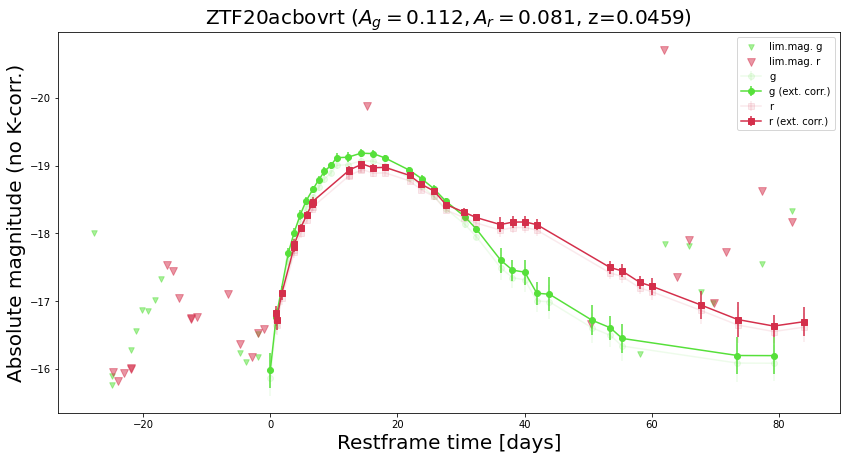

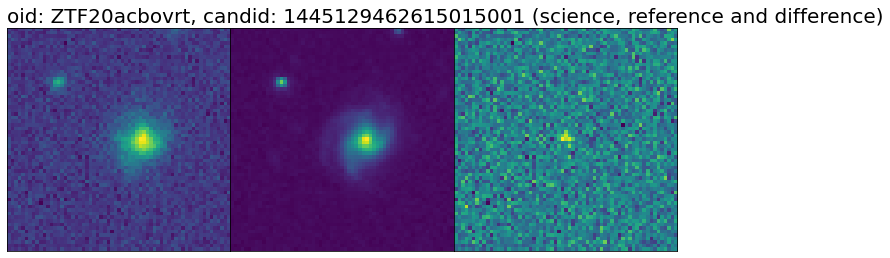

In [23]:
results = getSNdata(seloid, doLC=True, doext=True, dostamp=True, doDELIGHT=True, doNED=True, doredshift=True);

The supernova peaks around -19 magnitudes, which is typical for SNe Ia.

## Using Aladin to select the host galaxy from NED  <a class="anchor" id="host"></a>

With these two functions you should be able to hover over the NED sources near the SNe and see whether NED has a registered redshift. This can be used as a sanity check.

In [24]:
info = widgets.HTML()

def process_objectHovered(data):
    
    output = '<font color="red">'
    # NED
    if data["data"]["cat_name"] == "Ned":
        output = "<h2>NED</h2>"
        sel_keys = ["Object Name", "Separation", "RA", "DEC", "Type", "Redshift", "Redshift Flag", "Magnitude and Filter"]
    for key in sel_keys:
        if key in data["data"].keys():
            output += "<p><font size='1'>%s: %s</p>" % (key, data["data"][key])
    info.value =  '%s' % output

In [25]:
def show_host(results):
    aladin= ipyal.Aladin(target='%s %s' % (float(results["stats"].meanra), float(results["stats"].meandec)), 
                fov=0.04, survey='P/PanSTARRS/DR1/color-z-zg-g',
                reticle_size= 64,
                layout=Layout(width='70%'))
    box_layout = Layout(display='flex', flex_flow='row', align_items='stretch', width='100%')
    box = Box(children=[aladin, info], layout=box_layout)
    display(box)
    if "ned_table" in results:
        results["ned_table"]["cat_name"] = Column(["Ned"], name="cat_name")
        aladin.add_table(results["ned_table"])
    aladin.add_listener('objectHovered', process_objectHovered)
    print("Hover mouse to see information about catalog objects")

In [26]:
show_host(results)

Box(children=(Aladin(fov=0.04, layout=Layout(width='70%'), options=['allow_full_zoomout', 'coo_frame', 'fov', …

Hover mouse to see information about catalog objects


If you hover over the galaxy's NED reported position, you can confirm the redshift. 

Can you expand this notebook to get photometric redshifts from SDSS?

# Query many SN Ia candidates using the client <a class="anchor" id="sneiaclient"></a>

The ALeRCE client allows users to access the ALeRCE API and do simple queries to our database. You can get information about each command using the help command. Before doing this let's discuss the taxonomies used by the ALeRCE classifiers. 

## Classifiers, taxonomies and numeric mappings

There are two classifiers used in ALeRCE:

1. A stamp based classifier (Carrasco-Davis et al. 2020), which classifies objects based on their first image stamps. The purpose of this classifier is to trigger alerts for young SN candidates and other objects.
2. A light curve based classifier (Sánchez-Sáez et al. 2020), which classifies objects based on their light curve. The purpose of this classifier is to provide a more refined classification starting with at least 6 detections in a given band.

Each classifier has its own taxonomy, which is more refined for the light curve classifier. 

The stamp classifier contains the following classes:
* `agn`
* `sn`
* `vs`
* `asteroid`
* `bogus`
    
The late classifier uses the light curve information and contains the following classes:

* `SNIa`
* `SNIbc`
* `SNII`
* `SLSN`
* `QSO`
* `AGN`
* `Blazar`
* `CV/Nova`
* `YSO`
* `DSCT`
* `CEP`
* `LPV`
* `RRL`
* `E`
* `Periodic-Other`

The taxonomy from the light curve classifier is shown below:
![Taxonomy](figures/taxonomy_tree.png)


The light curve classifier classification is explained in detail in Sánchez-Saéz et al. 2021. Its confusion matrix is shown below:

![SanchezSaez+2020](figures/SanchezSaez+2020_confusion.png)

The recall as a function of magnitude is shown below (note the SN are grouped in this figure)
![SanchezSaez+2020](figures/SanchezSaez+2020_recall.png)

## Query many objects using the client

We will now query the top 1000 SN Ia candidates which exploded at least 70 days after ZTF's 1st light (on Nov 2017), that have a probability > 0.4 of being a SNe Ia according to the light curve classifier, and that have between 10 and 50 detections. We will output the result of the query directly as a pandas dataframe.

In [27]:
min_firstmjd = Time("2017-11-01T00:00:00", format="isot", scale="utc").mjd + 70

SNe = client.query_objects(classifier="lc_classifier",
                           class_name="SNIa", 
                           probability=0.4,
                           ndet=[10, 50],
                           order_by="probability",
                           order_mode="DESC",
                           first_mjd=[min_firstmjd, None],
                           page_size=1000, format='pandas')
print(SNe.shape)
SNe.set_index("oid", inplace=True)
SNe.head()

(1000, 23)


ndethist  ncovhist  mjdstarthist    mjdendhist  corrected  \
oid                                                                      
ZTF20acobvxk      102       502  59149.448125  59204.198831      False   
ZTF22aalpfln       59      2921  59724.250000  59766.250000      False   
ZTF21abuyhau       53      2702  59448.184097  59478.194873      False   
ZTF21abywdxt       44      1171  59464.267917  59502.204410      False   
ZTF22abqdmwt       28       699  59877.250000  59932.250000      False   

              stellar  ndet   g_r_max  g_r_max_corr  g_r_mean  ...  \
oid                                                            ...   
ZTF20acobvxk    False    37 -0.185314      0.588599  0.071720  ...   
ZTF22aalpfln    False    28 -0.179750           NaN  0.170184  ...   
ZTF21abuyhau    False    28 -0.180090      0.486082 -0.071212  ...   
ZTF21abywdxt    False    27 -0.098903           NaN  0.024772  ...   
ZTF22abqdmwt    False    21 -0.086032           NaN  0.009395  ...   

                   lastmjd    deltajd      meanra    meandec   sigmara  \
oid                                                                      
ZTF20acobvxk  59204.198831  54.750706   37.673533 -14.569121  0.000080   
ZTF22aalpfln  59766.241782  41.892627  224.503742  49.953109  0.000049   
ZTF21abuyhau  59478.194873  28.030926  244.075462  37.636849  0.000064   
ZTF21abywdxt  59502.204410  37.007465  326.503610  21.962614  0.000025   
ZTF22abqdmwt  59932.210451  53.900000   28.288162 -14.140191  0.000040   

              sigmadec  class     classifier probability      step_id_corr  
oid                                                                         
ZTF20acobvxk  0.000059   SNIa  lc_classifier    0.722000   corr_bulk_0.0.1  
ZTF22aalpfln  0.000022   SNIa  lc_classifier    0.722000               dev  
ZTF21abuyhau  0.000032   SNIa  lc_classifier    0.720000  correction_1.0.6  
ZTF21abywdxt  0.000023   SNIa  lc_classifier    0.716564  correction_1.0.6  
ZTF22abqdmwt  0.000052   SNIa  lc_classifier    0.714568             1.1.6  

[5 rows x 22 columns]

Here you can see the fields available in the dataframe

In [28]:
", ".join(list(SNe))

'ndethist, ncovhist, mjdstarthist, mjdendhist, corrected, stellar, ndet, g_r_max, g_r_max_corr, g_r_mean, g_r_mean_corr, firstmjd, lastmjd, deltajd, meanra, meandec, sigmara, sigmadec, class, classifier, probability, step_id_corr'

This table contains the unique object identifier `oid` as index, the classification class `class`, whether its light curve was corrected `corrected` (see discussion in https://alerce.science/alerce-pipeline/), the light curve length `deltjd`, the time of first detection `firstmjd`, the g-r color at maximum `g_r_max`, the corrected g-r color at maximum `g_r_max_corr`, the mean g-r color `g_r_mean`, the corrected mean g-r color `g_r_mean_corr`, the time of last detection `lastmjd`, the mean declination `meandec`, the mean right ascension `meanra`, the latest time of a raw SNR>3 detection `mjdendhist`, the earliest time of a raw SNR>3 detection `mjdstarthist`, the number of times the candidate fell inside on a ZTF observation `ncovhist`, the number of detections `ndet`, the number of raw SNR>3 detections `ndethist`, the classification probability `probability`, the declination standard deviation `sigmadec`, the right ascension standard deviation `sigmara`, whether the object is likely stellar `stellar`, and the version of the preprocessing step `step_id_corr`.

Let us look at the distribution of peak g-r colors

Text(0.5, 0, 'g-r @ max')

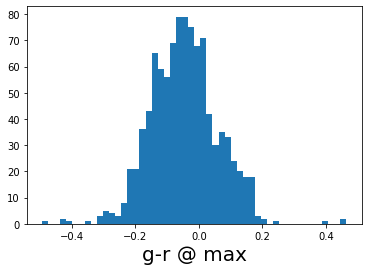

In [29]:
fig, ax = plt.subplots()
ax.hist(SNe.g_r_max, bins=50)
ax.set_xlabel("g-r @ max", fontsize=20)

Let us also look at distribution of image difference number of detections.

Text(0.5, 0, 'Number of detections')

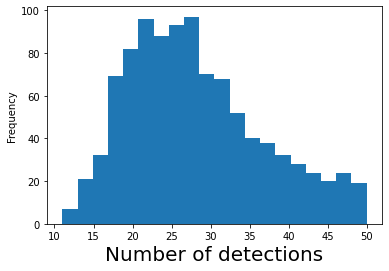

In [30]:
fig, ax = plt.subplots()
SNe.ndet.plot.hist(ax=ax, label="ndet", bins=20)
ax.set_xlabel("Number of detections", fontsize=20)

## Visualize two more examples

Finally, we will use the function from the previous section to plot two more examples: one where the redshift can be found and another where it is not found.

Querying basic stats...
Querying detections...
Querying non detections...
Querying Galactic extinction...
Plot the apparent magnitude light curve...
Using DELIGHT to estimate the host position...
stack_r_ra343.298556_dec11.113533_arcsec120_skycell1586.076.fits
stack_r_ra217.066348_dec-1.982149_arcsec120_skycell1286.052.fits
stack_r_ra208.777244_dec54.304888_arcsec120_skycell2381.055.fits
stack_r_ra231.582920_dec50.680863_arcsec120_skycell2328.068.fits
stack_r_ra359.866189_dec17.865197_arcsec120_skycell1678.045.fits
stack_r_ra14.724656_dec29.943803_arcsec120_skycell1933.042.fits
stack_r_ra260.101637_dec55.214638_arcsec120_skycell2389.087.fits
stack_r_ra200.261022_dec20.098752_arcsec120_skycell1811.007.fits
stack_r_ra89.469710_dec-21.552352_arcsec120_skycell0817.066.fits
stack_r_ra24.330464_dec4.801942_arcsec120_skycell1418.024.fits
stack_r_ra265.492915_dec47.104484_arcsec120_skycell2272.073.fits
stack_r_ra30.922588_dec52.150494_arcsec120_skycell2354.007.fits
stack_r_ra359.636873_dec-1.1

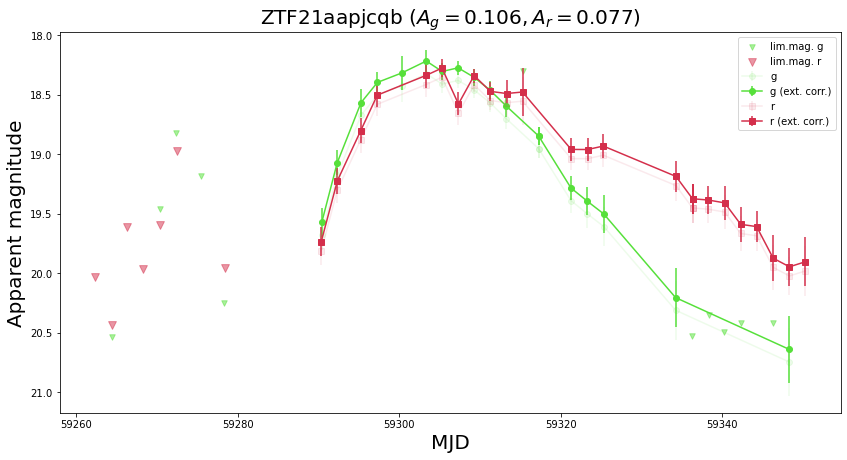

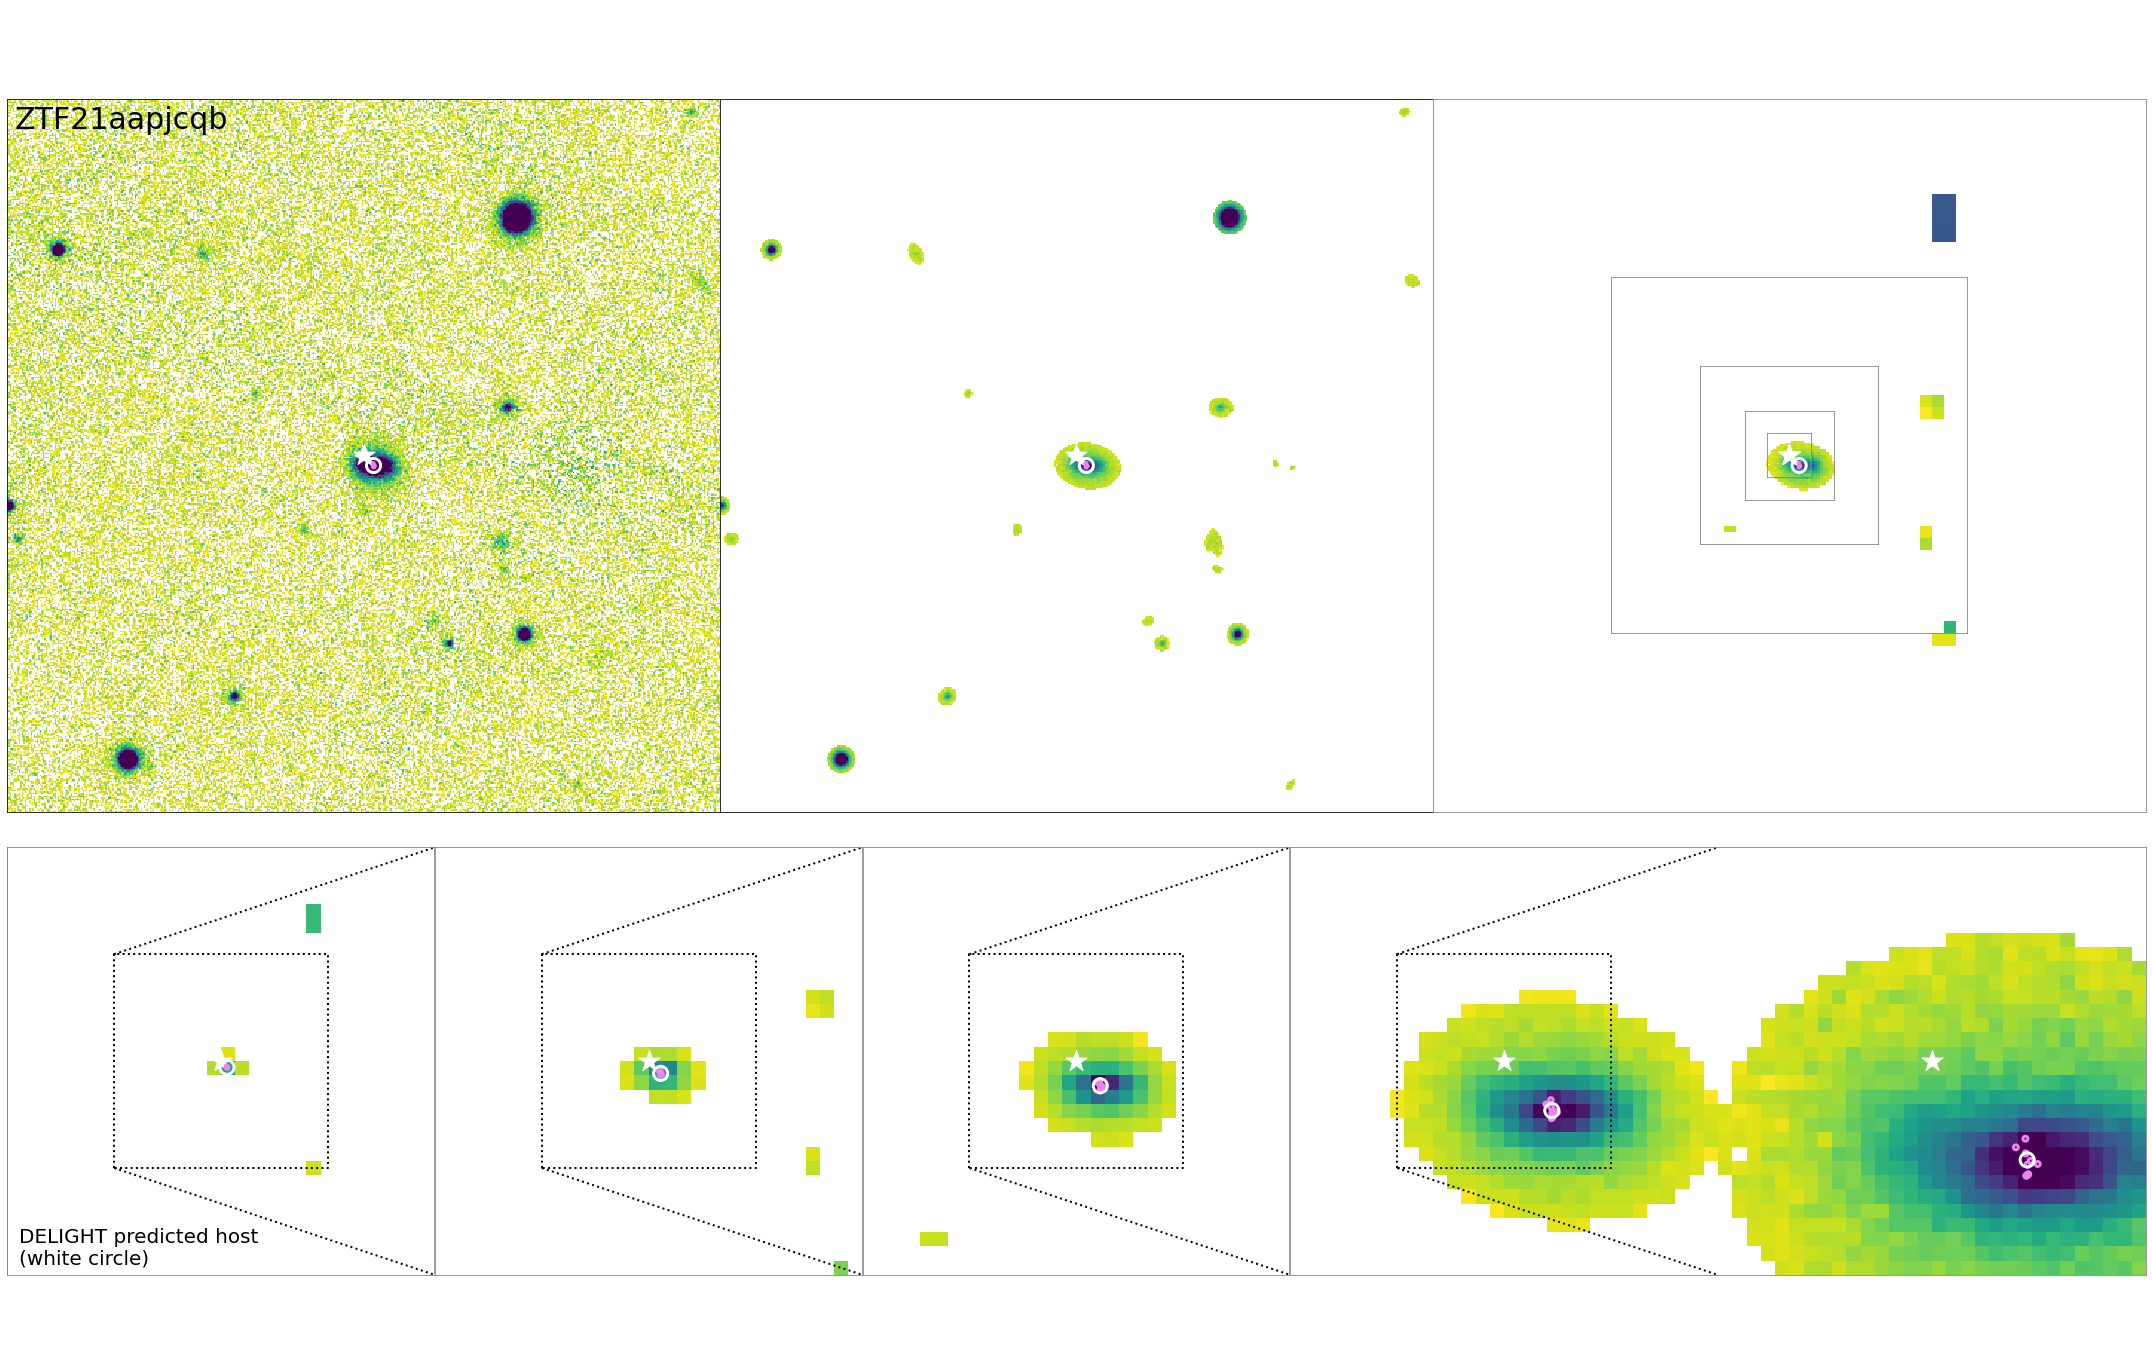

ra       dec     dist  \
oid                                           
ZTF21aapjcqb  196.672453  9.331755  0.00148   

                                                       filename  \
oid                                                               
ZTF21aapjcqb  stack_r_ra196.672453_dec9.331755_arcsec120_sky...   

                                                            wcs  \
oid                                                               
ZTF21aapjcqb  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF21aapjcqb  <SkyCoord (ICRS): (ra, dec) in deg\n    (196.6...   

                             xSN                 ySN  dx  dy  ...  \
oid                                                           ...   
ZTF21aapjcqb  239.75823801658044  239.89863175531354   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF21aapjcqb  [[7.429189682006836, -7.21821403503418], [6.63...    6.69318   

             dy_delight  std_delight  \
oid                                    
ZTF21aapjcqb  -6.930918     0.930689   

                                       host_coords_delight_pred  \
oid                                                               
ZTF21aapjcqb  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF21aapjcqb  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   196.67199   

              dec_delight      ra_sex   dec_sex  
oid                                              
ZTF21aapjcqb     9.331271  196.671972  9.331235  

[1 rows x 25 columns]

Using Ned to query the host position...


<Table length=4>
 No.         Object Name            RA     ... Diameter Points Associations
                                 degrees   ...                             
int32           str30            float64   ...      int32         int32    
----- ------------------------- ---------- ... --------------- ------------
    1 WISEA J130641.27+091952.3    196.672 ...               4            0
    2  SDSS J130641.37+091944.7  196.67239 ...               4            0
    3                SN 2021fwy  196.67241 ...               0            0
    4  SDSS J130642.08+091941.9  196.67537 ...               4            0

Redshift found! 0.072832
Plotting the absolute magnitude light curve...
Redshift: 0.072832, Distance modulus: 37.57741550334636


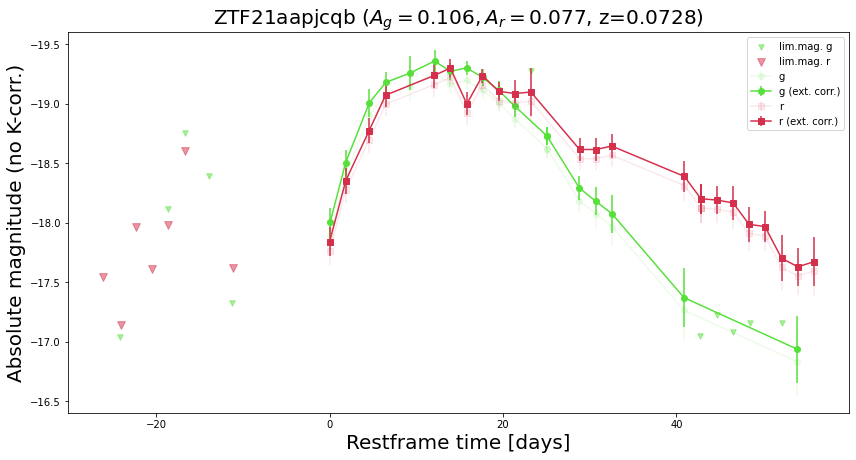

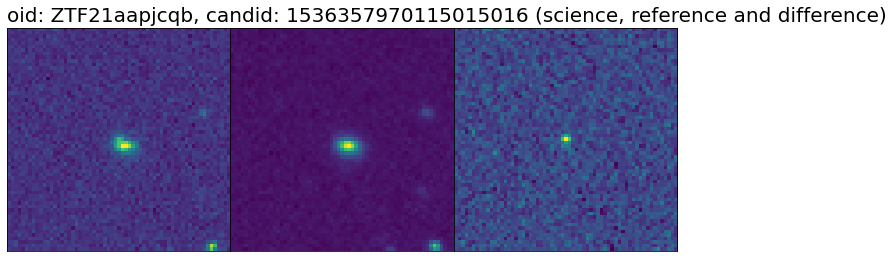

In [31]:
getSNdata('ZTF21aapjcqb', doLC = True, doext=True, dostamp=True, doDELIGHT=True, doNED=True, doredshift=True);

Querying basic stats...
Querying detections...
Querying non detections...
Querying Galactic extinction...
Plot the apparent magnitude light curve...
Using DELIGHT to estimate the host position...
stack_r_ra343.298556_dec11.113533_arcsec120_skycell1586.076.fits
stack_r_ra217.066348_dec-1.982149_arcsec120_skycell1286.052.fits
stack_r_ra208.777244_dec54.304888_arcsec120_skycell2381.055.fits
stack_r_ra231.582920_dec50.680863_arcsec120_skycell2328.068.fits
stack_r_ra359.866189_dec17.865197_arcsec120_skycell1678.045.fits
stack_r_ra14.724656_dec29.943803_arcsec120_skycell1933.042.fits
stack_r_ra260.101637_dec55.214638_arcsec120_skycell2389.087.fits
stack_r_ra200.261022_dec20.098752_arcsec120_skycell1811.007.fits
stack_r_ra89.469710_dec-21.552352_arcsec120_skycell0817.066.fits
stack_r_ra24.330464_dec4.801942_arcsec120_skycell1418.024.fits
stack_r_ra265.492915_dec47.104484_arcsec120_skycell2272.073.fits
stack_r_ra30.922588_dec52.150494_arcsec120_skycell2354.007.fits
stack_r_ra359.636873_dec-1.1

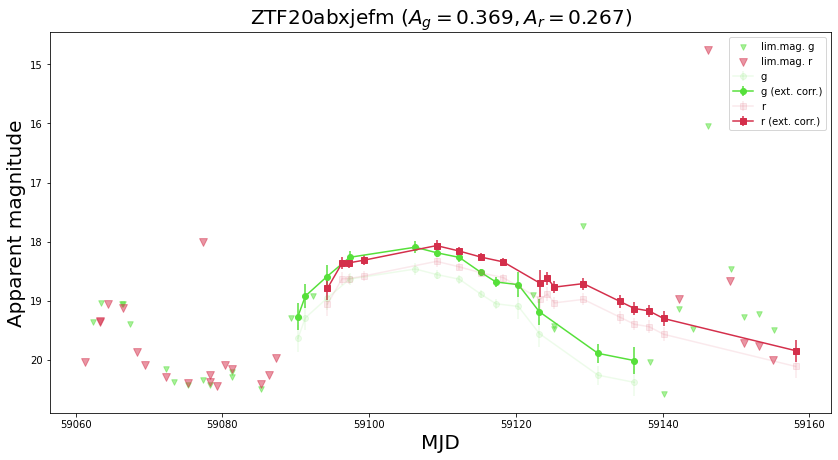

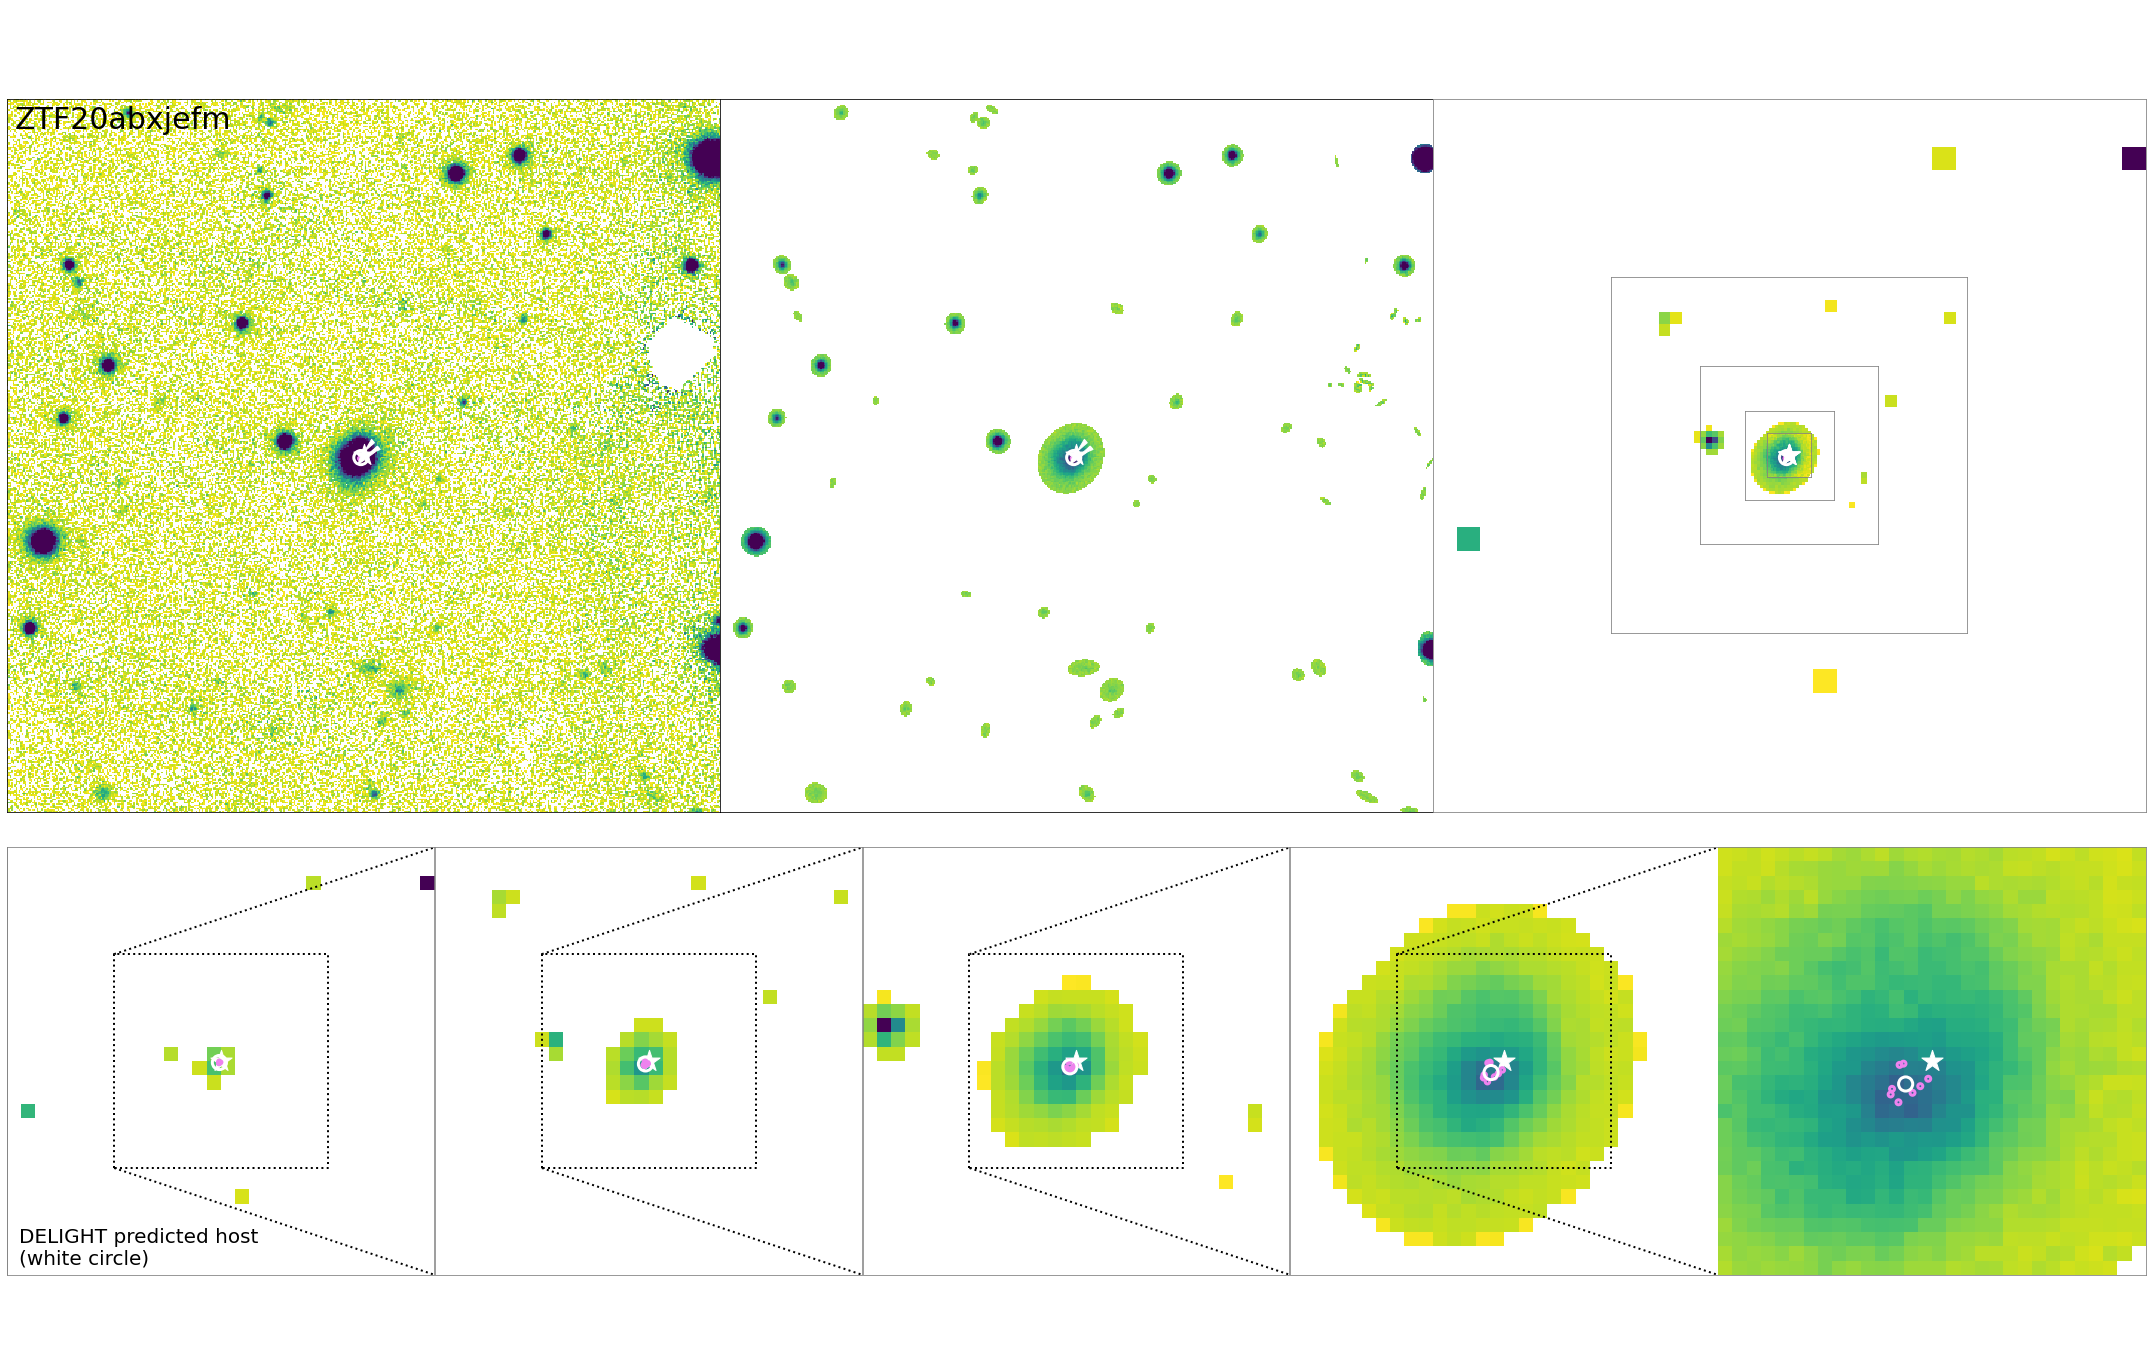

ra        dec      dist  \
oid                                             
ZTF20abxjefm  320.901264  13.817507  0.001972   

                                                       filename  \
oid                                                               
ZTF20abxjefm  stack_r_ra320.901264_dec13.817507_arcsec120_sk...   

                                                            wcs  \
oid                                                               
ZTF20abxjefm  WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE :...   

                                                      sn_coords  \
oid                                                               
ZTF20abxjefm  <SkyCoord (ICRS): (ra, dec) in deg\n    (320.9...   

                             xSN                ySN  dx  dy  ...  \
oid                                                          ...   
ZTF20abxjefm  239.90531966224808  240.2302163580871   1   1  ...   

                                           dxdy_delight_rotflip dx_delight  \
oid                                                                          
ZTF20abxjefm  [[-0.24895618855953217, -1.2415302991867065], ...  -1.831247   

             dy_delight  std_delight  \
oid                                    
ZTF20abxjefm  -1.607056     1.271511   

                                       host_coords_delight_pred  \
oid                                                               
ZTF20abxjefm  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...   

                                           host_coords_sex_pred  ra_delight  \
oid                                                                           
ZTF20abxjefm  <SkyCoord (FK5: equinox=2000.0): (ra, dec) in ...  320.901401   

              dec_delight      ra_sex    dec_sex  
oid                                               
ZTF20abxjefm      13.8174  320.901575  13.817349  

[1 rows x 25 columns]

Using Ned to query the host position...


<Table length=2>
 No.         Object Name            RA     ... Diameter Points Associations
                                 degrees   ...                             
int32           str30            float64   ...      int32         int32    
----- ------------------------- ---------- ... --------------- ------------
    1                SN 2020sga  320.90125 ...               0            0
    2 WISEA J212336.38+134901.9  320.90154 ...               0            0

No redshift could be found, cannot plot the absolute magnitudes.


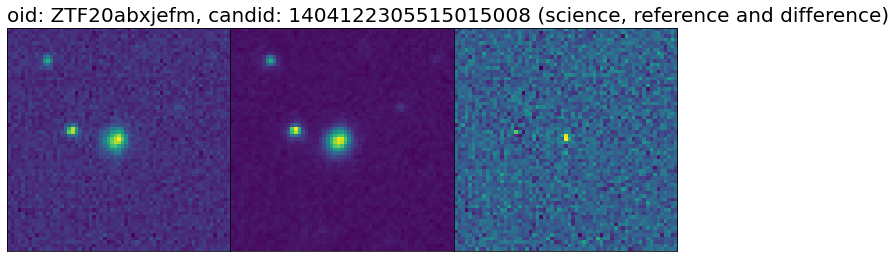

In [32]:
getSNdata('ZTF20abxjefm', doLC = True, doext=True, dostamp=True, doDELIGHT=True, doNED=True, doredshift=True);

# Query SN candidates using a direct DB connection <a class="anchor" id="sneiadb"></a>

The previous way of querying candidates is good for relatively simple queries. However, if we want to do more complex queries the best solution may be to connect directly to the DB. We show how to do this here with different SN related use cases.

In this section you will query the tables:
* `object`: filter and bandpass aggregated properties per object
* `probability`: classification probabilities
* `magstat`: time aggregated bandpass dependent properties per object
* `ps1_ztf`: closest PanSTARRS xmatch properties (within 2")
* `detection`: individual detections, time and bandpass disaggregated
* `feature`: advanced object features, used for machine learning classification
* `non_detection`: limiting magnitudes in previous observations, the largest table of all

You will need to use the read-only credentials available in the repository. Please be kind with the queries 😅

In [ ]:
url = "https://raw.githubusercontent.com/alercebroker/usecases/master/alercereaduser_v4.json"
params = requests.get(url).json()['params']

Now we open a connection to the DB

In [ ]:
engine = sa.create_engine(f"postgresql+psycopg2://{params['user']}:{params['password']}@{params['host']}/{params['dbname']}")
engine.begin()

We will first show all the available tables for you to explore.

In [ ]:
query = """
SELECT table_name  FROM information_schema.tables
WHERE table_schema='alerce'
ORDER BY table_name;
"""
tables = pd.read_sql_query(query, con=engine)
tables.sort_values(by="table_name")

You can see all the tables used in the new version of our database. The most relevant tables are, moving from less to more aggregation:

* `non_detection`: one row per non-detection per object, the limiting magnitudes
* `detection`: one row per detection, light curves and other relevant time dependent information
* `data_quality`: one row per detection, data quality related time dependent information
* `magstat`: one row per object per filter, statistics per bandpass per object
* `object`: one row per object, basic object statistics
* `probability`: one row per object per classifier and class, the probabilities of every object
* `reference`: one row per object per reference image, object statistics for every reference image used
* `feature`: one row per object per feature, object computed features
* `xmatch`: one row per object per external catalog, the table that points to the detailed xmatch tables
* `allwise, ps1_ztf, gaia_ztf, ss_stf`: one row per object, xmatch tables


For completeness, we now show all columns available in all tables!

In [ ]:
alltabs = []
for tab in sorted(tables.table_name):
    cols = pd.DataFrame()
    query = "select column_name, data_type from information_schema.columns where table_name = '%s';" % tab
    results = pd.read_sql_query(query, con=engine)
    results["table"] = tab
    alltabs.append(results)
dftab = pd.concat(alltabs)
pd.options.display.max_rows = 999
display(dftab[["table", "column_name", "data_type"]])
pd.options.display.max_rows = 101

## Object and probability tables

Now we can do a query asking for SN candidates. For this it is important to understand the probability table. This table contains all the classifications probabilities, for every object, every classifier, and every available class. An object will be in many rows of this table, with the idea of being flexible to future changes in the taxonomy. 

For example, an object classified by the light curve classifier (classifier_name=lc_classifier) will appear in all the available classes, e.g., class_name='SNIa' or class_name='AGN', independently of whether this is the most likely class. The most likely class can be quickly obtained with the ranking column (ranking=1). For example, if we want to find the probabilities of the objects most likely to be RR Lyrae, we would look for objects with classifier_name='lc_classifier', class_name='RRL' and ranking=1. The probabilities will be given by the probability column. 

Now, we will query objects that are most likely to be SNe (ranking=1 among classes SNIa, SNII, SNIbc, SLSN) with a probability larger than 0.2. For this we will do a complex query, including an inner join between object and probability and selecting those oids to be considered from probability.

WARNING: the number of objects may increase with time. Please be careful when decreasing the minimum probability.

~12 s

In [41]:
query='''
SELECT
    object.oid, object.meanra, object.meandec, object.ndet,
    object.firstMJD, object.deltajd, object.g_r_max,
    probability.classifier_name, probability.class_name, probability.classifier_version,
    probability.ranking, probability.probability
FROM
    object INNER JOIN probability
    ON object.oid=probability.oid
WHERE
    probability.classifier_name='lc_classifier' 
    AND object.oid IN 
(
SELECT
    oid
FROM
    probability
WHERE
    classifier_name='lc_classifier'
    AND class_name IN ('SNIa', 'SNIbc', 'SNII', 'SLSN')
    AND ranking=1
    AND probability > 0.5
)
'''

SNe = pd.read_sql_query(query, con=engine)
print(SNe.shape)
SNe.set_index('oid', inplace=True)
SNe.head()

/home/fforster/anaconda3/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


(51825, 12)


meanra   meandec  ndet      firstmjd    deltajd   g_r_max  \
oid                                                                           
ZTF22abkzwso  111.539685  6.642854    17  59853.495671  35.948252 -0.177183   
ZTF22abkzwso  111.539685  6.642854    17  59853.495671  35.948252 -0.177183   
ZTF22abkzwso  111.539685  6.642854    17  59853.495671  35.948252 -0.177183   
ZTF22abkzwso  111.539685  6.642854    17  59853.495671  35.948252 -0.177183   
ZTF22abkzwso  111.539685  6.642854    17  59853.495671  35.948252 -0.177183   

             classifier_name class_name     classifier_version  ranking  \
oid                                                                       
ZTF22abkzwso   lc_classifier        AGN  hierarchical_rf_1.1.0       15   
ZTF22abkzwso   lc_classifier     Blazar  hierarchical_rf_1.1.0       11   
ZTF22abkzwso   lc_classifier        CEP  hierarchical_rf_1.1.0        7   
ZTF22abkzwso   lc_classifier    CV/Nova  hierarchical_rf_1.1.0        5   
ZTF22abkzwso   lc_classifier       DSCT  hierarchical_rf_1.1.0        8   

              probability  
oid                        
ZTF22abkzwso     0.000140  
ZTF22abkzwso     0.000952  
ZTF22abkzwso     0.003880  
ZTF22abkzwso     0.011592  
ZTF22abkzwso     0.002600

Let's look at all the appearances of the first SN above

In [42]:
SNe.loc[SNe.index == SNe.index[0]]

meanra   meandec  ndet      firstmjd    deltajd   g_r_max  \
oid                                                                           
ZTF22abkzwso  111.539685  6.642854    17  59853.495671  35.948252 -0.177183   
ZTF22abkzwso  111.539685  6.642854    17  59853.495671  35.948252 -0.177183   
ZTF22abkzwso  111.539685  6.642854    17  59853.495671  35.948252 -0.177183   
ZTF22abkzwso  111.539685  6.642854    17  59853.495671  35.948252 -0.177183   
ZTF22abkzwso  111.539685  6.642854    17  59853.495671  35.948252 -0.177183   
ZTF22abkzwso  111.539685  6.642854    17  59853.495671  35.948252 -0.177183   
ZTF22abkzwso  111.539685  6.642854    17  59853.495671  35.948252 -0.177183   
ZTF22abkzwso  111.539685  6.642854    17  59853.495671  35.948252 -0.177183   
ZTF22abkzwso  111.539685  6.642854    17  59853.495671  35.948252 -0.177183   
ZTF22abkzwso  111.539685  6.642854    17  59853.495671  35.948252 -0.177183   
ZTF22abkzwso  111.539685  6.642854    17  59853.495671  35.948252 -0.177183   
ZTF22abkzwso  111.539685  6.642854    17  59853.495671  35.948252 -0.177183   
ZTF22abkzwso  111.539685  6.642854    17  59853.495671  35.948252 -0.177183   
ZTF22abkzwso  111.539685  6.642854    17  59853.495671  35.948252 -0.177183   
ZTF22abkzwso  111.539685  6.642854    17  59853.495671  35.948252 -0.177183   

             classifier_name      class_name     classifier_version  ranking  \
oid                                                                            
ZTF22abkzwso   lc_classifier             AGN  hierarchical_rf_1.1.0       15   
ZTF22abkzwso   lc_classifier          Blazar  hierarchical_rf_1.1.0       11   
ZTF22abkzwso   lc_classifier             CEP  hierarchical_rf_1.1.0        7   
ZTF22abkzwso   lc_classifier         CV/Nova  hierarchical_rf_1.1.0        5   
ZTF22abkzwso   lc_classifier            DSCT  hierarchical_rf_1.1.0        8   
ZTF22abkzwso   lc_classifier               E  hierarchical_rf_1.1.0       10   
ZTF22abkzwso   lc_classifier             LPV  hierarchical_rf_1.1.0       13   
ZTF22abkzwso   lc_classifier  Periodic-Other  hierarchical_rf_1.1.0        9   
ZTF22abkzwso   lc_classifier             QSO  hierarchical_rf_1.1.0       14   
ZTF22abkzwso   lc_classifier             RRL  hierarchical_rf_1.1.0        6   
ZTF22abkzwso   lc_classifier            SLSN  hierarchical_rf_1.1.0        2   
ZTF22abkzwso   lc_classifier            SNIa  hierarchical_rf_1.1.0        1   
ZTF22abkzwso   lc_classifier           SNIbc  hierarchical_rf_1.1.0        3   
ZTF22abkzwso   lc_classifier            SNII  hierarchical_rf_1.1.0        4   
ZTF22abkzwso   lc_classifier             YSO  hierarchical_rf_1.1.0       12   

              probability  
oid                        
ZTF22abkzwso     0.000140  
ZTF22abkzwso     0.000952  
ZTF22abkzwso     0.003880  
ZTF22abkzwso     0.011592  
ZTF22abkzwso     0.002600  
ZTF22abkzwso     0.002240  
ZTF22abkzwso     0.000480  
ZTF22abkzwso     0.002360  
ZTF22abkzwso     0.000476  
ZTF22abkzwso     0.008440  
ZTF22abkzwso     0.179676  
ZTF22abkzwso     0.508116  
ZTF22abkzwso     0.154560  
ZTF22abkzwso     0.123648  
ZTF22abkzwso     0.000840

The ALeRCE classifier has evolved over time, let's look at the different classifier versions and how many rows there are for each of them.

In [53]:
SNe.classifier_version.value_counts()

hierarchical_rf_1.1.0    50745
lc_classifier_1.1.13      1080
Name: classifier_version, dtype: int64

We could select one of the two classifiers, but we will instead give priority to the latest classifier when available.

In [54]:
# SNe that have two classification versions
repeated = set(SNe.loc[SNe.classifier_version == "hierarchical_rf_1.1.0"].index.unique()).\
intersection(SNe.loc[SNe.classifier_version == "lc_classifier_1.1.13"].index.unique())

In [55]:
SNe = pd.concat([SNe.loc[SNe.classifier_version == "lc_classifier_1.1.13"], 
           SNe.loc[~SNe.index.isin(repeated) & (SNe.classifier_version=="hierarchical_rf_1.1.0")]])

In [56]:
SNe

meanra   meandec  ndet      firstmjd     deltajd   g_r_max  \
oid                                                                            
ZTF24aaejkyp  183.545531 -0.833745    15  60351.372431   55.985347       NaN   
ZTF24aaejkyp  183.545531 -0.833745    15  60351.372431   55.985347       NaN   
ZTF24aaejkyp  183.545531 -0.833745    15  60351.372431   55.985347       NaN   
ZTF24aaejkyp  183.545531 -0.833745    15  60351.372431   55.985347       NaN   
ZTF24aaejkyp  183.545531 -0.833745    15  60351.372431   55.985347       NaN   
...                  ...       ...   ...           ...         ...       ...   
ZTF21aazqmfh  235.920758  3.133753    44  59324.377986  109.834329 -0.206928   
ZTF21aazqmfh  235.920758  3.133753    44  59324.377986  109.834329 -0.206928   
ZTF21aazqmfh  235.920758  3.133753    44  59324.377986  109.834329 -0.206928   
ZTF21aazqmfh  235.920758  3.133753    44  59324.377986  109.834329 -0.206928   
ZTF21aazqmfh  235.920758  3.133753    44  59324.377986  109.834329 -0.206928   

             classifier_name class_name     classifier_version  ranking  \
oid                                                                       
ZTF24aaejkyp   lc_classifier        AGN   lc_classifier_1.1.13       11   
ZTF24aaejkyp   lc_classifier     Blazar   lc_classifier_1.1.13       12   
ZTF24aaejkyp   lc_classifier        CEP   lc_classifier_1.1.13        7   
ZTF24aaejkyp   lc_classifier    CV/Nova   lc_classifier_1.1.13       13   
ZTF24aaejkyp   lc_classifier       DSCT   lc_classifier_1.1.13        9   
...                      ...        ...                    ...      ...   
ZTF21aazqmfh   lc_classifier       SLSN  hierarchical_rf_1.1.0        1   
ZTF21aazqmfh   lc_classifier       SNIa  hierarchical_rf_1.1.0        3   
ZTF21aazqmfh   lc_classifier      SNIbc  hierarchical_rf_1.1.0        4   
ZTF21aazqmfh   lc_classifier       SNII  hierarchical_rf_1.1.0        2   
ZTF21aazqmfh   lc_classifier        YSO  hierarchical_rf_1.1.0       14   

              probability  
oid                        
ZTF24aaejkyp     0.000000  
ZTF24aaejkyp     0.000000  
ZTF24aaejkyp     0.000340  
ZTF24aaejkyp     0.000000  
ZTF24aaejkyp     0.000156  
...                   ...  
ZTF21aazqmfh     0.630448  
ZTF21aazqmfh     0.048496  
ZTF21aazqmfh     0.039836  
ZTF21aazqmfh     0.147220  
ZTF21aazqmfh     0.005040  

[51000 rows x 11 columns]

You can see that each object appears in many rows of the table, one row per class in the taxonomy of the classifier.

We will create a view of the table above by converting class names into columns, using multi indexing for probabilities and rankings. Note that this is not a copy, but only a different view of the same table.

In [58]:
SNe_p = SNe.pivot(columns="class_name")#, values=['probability', 'ranking'])
SNe_p.head()

meanra                                                  \
class_name           AGN      Blazar         CEP     CV/Nova        DSCT   
oid                                                                        
ZTF17aaahhwn   69.419499   69.419499   69.419499   69.419499   69.419499   
ZTF18aadaexi  125.241561  125.241561  125.241561  125.241561  125.241561   
ZTF18aadlaxo  120.648992  120.648992  120.648992  120.648992  120.648992   
ZTF18aadvwyz   89.043010   89.043010   89.043010   89.043010   89.043010   
ZTF18aadzfso  106.823649  106.823649  106.823649  106.823649  106.823649   

                                                                             \
class_name             E         LPV Periodic-Other         QSO         RRL   
oid                                                                           
ZTF17aaahhwn   69.419499   69.419499      69.419499   69.419499   69.419499   
ZTF18aadaexi  125.241561  125.241561     125.241561  125.241561  125.241561   
ZTF18aadlaxo  120.648992  120.648992     120.648992  120.648992  120.648992   
ZTF18aadvwyz   89.043010   89.043010      89.043010   89.043010   89.043010   
ZTF18aadzfso  106.823649  106.823649     106.823649  106.823649  106.823649   

              ... probability                                               \
class_name    ...           E       LPV Periodic-Other       QSO       RRL   
oid           ...                                                            
ZTF17aaahhwn  ...    0.000000  0.000000       0.000000  0.000000  0.000000   
ZTF18aadaexi  ...    0.000280  0.000040       0.000180  0.000000  0.001012   
ZTF18aadlaxo  ...    0.001472  0.000544       0.010016  0.000072  0.000736   
ZTF18aadvwyz  ...    0.000752  0.000160       0.001456  0.001176  0.000704   
ZTF18aadzfso  ...    0.000000  0.000000       0.000000  0.000096  0.000000   

                                                                
class_name        SLSN      SNII      SNIa     SNIbc       YSO  
oid                                                             
ZTF17aaahhwn  0.084000  0.106000  0.230000  0.580000  0.000000  
ZTF18aadaexi  0.063872  0.095808  0.504988  0.333332  0.000000  
ZTF18aadlaxo  0.056840  0.070560  0.558600  0.294000  0.000456  
ZTF18aadvwyz  0.076752  0.086592  0.580560  0.240096  0.002568  
ZTF18aadzfso  0.063744  0.119520  0.527880  0.284856  0.000312  

[5 rows x 150 columns]

You can access the probability, ranking, or any other column using multiindices:

In [59]:
SNe_p.loc[SNe_p.iloc[[0]].index].probability.SNIbc, SNe_p.loc[SNe_p.iloc[[0]].index].ranking.SNIbc

(oid
 ZTF17aaahhwn    0.58
 Name: SNIbc, dtype: float64,
 oid
 ZTF17aaahhwn    1
 Name: SNIbc, dtype: int64)

Let's look at the distribution of SNII probabilities for the objects most likely to be SNII.

Text(0.5, 0, 'SNII prob')

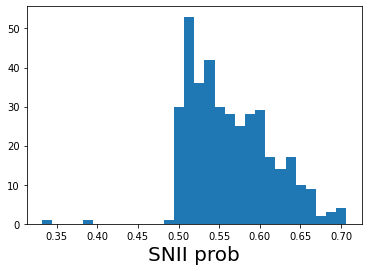

In [60]:
fig, ax = plt.subplots()
mask = (SNe_p.ranking.SNII == 1)
ax.hist(SNe_p.loc[mask].probability.SNII, bins=30)
ax.set_xlabel("SNII prob", fontsize=20)

Now we will focus on objects whose SN II probability is the 1st or 2nd most likely value. Let's compare their probabilities with SN Ia probabilities.

Text(0, 0.5, 'SNIa prob')

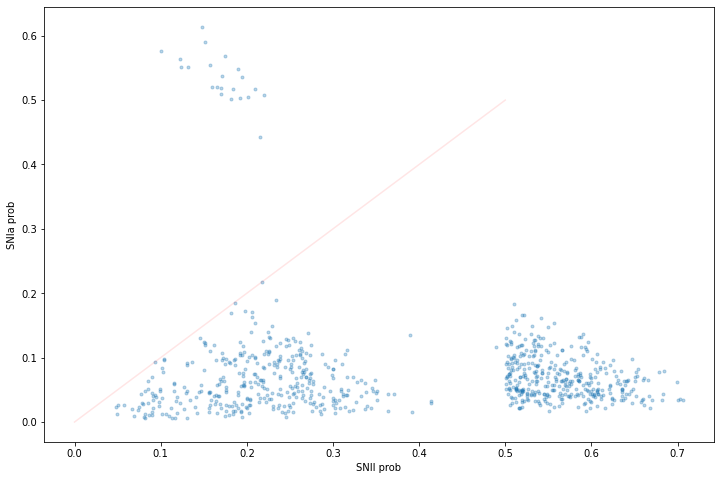

In [61]:
fig, ax = plt.subplots(figsize=(12, 8))
# objects whose first or second most likely class is SNe II
mask = SNe_p.ranking.SNII.isin([1, 2])

ax.scatter(SNe_p.loc[mask].probability.SNII, SNe_p.loc[mask].probability.SNIa, marker='.', alpha=0.3)
ax.plot([0, 0.5], [0, 0.5], c='r', alpha=0.1)
ax.set_xlabel("SNII prob")
ax.set_ylabel("SNIa prob")

You can see the objects whose most likely class is SN II at the probability values larger than 0.5. Then, you can see the objects whose second largest probability is SN II at lower values in the x-axis. A fraction of those are actually SNe Ia, seen at the y-axis values greater than 0.5.

Let's do the same with SNe Ibc and SNe II.

Text(0, 0.5, 'SNIbc prob')

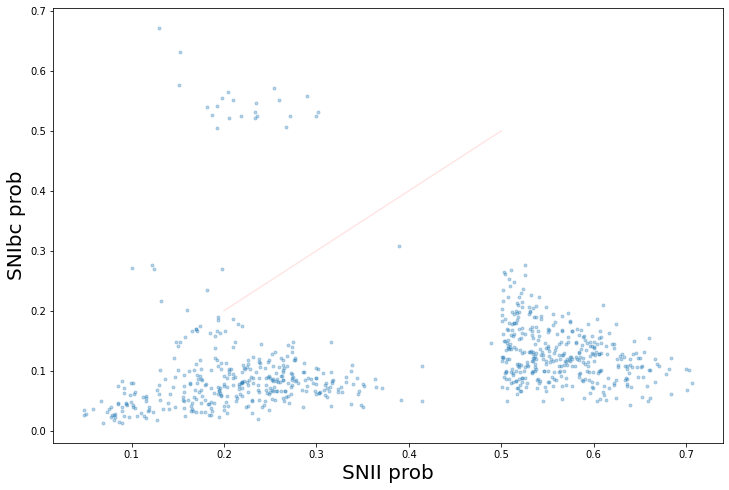

In [62]:
fig, ax = plt.subplots(figsize=(12, 8))
# objects whose first or second most likely class is SNe II
mask = SNe_p.ranking.SNII.isin([1, 2])

ax.scatter(SNe_p.loc[mask].probability.SNII, SNe_p.loc[mask].probability.SNIbc, marker='.', alpha=0.3)
ax.plot([0.2, 0.5], [0.2, 0.5], c='r', alpha=0.1)
ax.set_xlabel("SNII prob", fontsize=20)
ax.set_ylabel("SNIbc prob", fontsize=20)

You can see a similar distribution, but now you can also see some cases where the two probabilities are similar, when 0.5 > P(SN Ibc) > P(SN II).

Now let's compare the light curve lengths of SN II and SN Ia, which should the most obvious difference between SNe II and SNe Ia

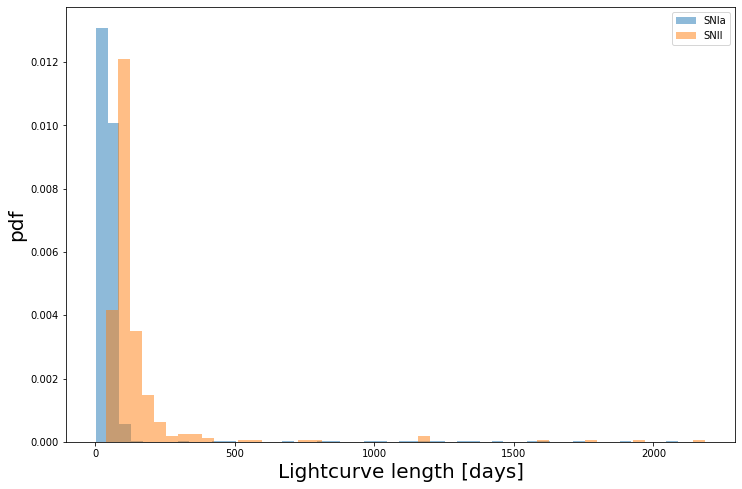

In [63]:
fig, ax = plt.subplots(figsize=(12, 8))
for idx, sn in enumerate(["SNIa", "SNII"]):
    mask = SNe_p.ranking[sn] == 1# & (SNe.class_name == sn)
    ax.hist(SNe_p.loc[mask].deltajd[sn], bins=50, label=sn, alpha=0.5, density=True)
ax.set_xlabel("Lightcurve length [days]", fontsize=20)
ax.set_ylabel("pdf", fontsize=20)
ax.legend()

We confirm that SNe II are longer lived than SNe Ia, but there are a few very long light curves that could be missclassifications. We will remove objects with lengths larger than 500 days.

In [64]:
SNe = SNe.loc[SNe.deltajd < 500]

## Magstat table

Let's now compare the peak magnitudes from SNe Ia and SNe II. Since these are statistics per band we need to access the table magstat:

~5 s

In [65]:
query = '''
SELECT
    *
FROM
    magstat
WHERE
    oid in (%s)
''' % ",".join(["'%s'" % oid for oid in SNe.loc[(SNe.ranking == 1)].index.unique()])
magstats = pd.read_sql_query(query, con=engine)
magstats.set_index("oid", inplace=True)
magstats.head()

/home/fforster/anaconda3/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


fid  stellar  corrected  ndet  ndubious  dmdt_first  dm_first  \
oid                                                                           
ZTF17aaahhwn    1    False      False     5         0    0.116263  0.442800   
ZTF17aaahhwn    2    False      False    11         0    0.039620  0.655100   
ZTF18aadaexi    1    False      False     7         4   -0.295468 -0.737956   
ZTF18aadaexi    2    False       True     4         0   -0.227054 -1.533942   
ZTF18aadlaxo    1    False       True    11         0   -0.008033 -0.473600   

              sigmadm_first   dt_first    magmean  ...  magmedian_corr  \
oid                                                ...                   
ZTF17aaahhwn     -19.530820   5.958727  20.284390  ...             NaN   
ZTF17aaahhwn     -19.313723  21.995949  19.784801  ...             NaN   
ZTF18aadaexi     -20.261162   1.854745  19.121931  ...       17.626450   
ZTF18aadaexi     -20.330927   6.023113  18.804493  ...       17.993822   
ZTF18aadlaxo     -20.291176  23.836205  18.825357  ...       17.162638   

              magmax_corr  magmin_corr  magsigma_corr  maglast_corr  \
oid                                                                   
ZTF17aaahhwn          NaN          NaN            NaN           NaN   
ZTF17aaahhwn          NaN          NaN            NaN           NaN   
ZTF18aadaexi    17.835085    17.561138       0.119450     17.835085   
ZTF18aadaexi    18.134071    16.862253       0.594258     18.043768   
ZTF18aadlaxo    17.406130    17.039974       0.132546     17.339497   

              magfirst_corr   firstmjd    lastmjd      step_id_corr  \
oid                                                                   
ZTF17aaahhwn            NaN  60168.430  60204.492             1.2.1   
ZTF17aaahhwn            NaN  60168.477  60208.496             1.2.1   
ZTF18aadaexi            NaN  59267.246  59293.156  correction_0.0.1   
ZTF18aadaexi      18.134071  59271.258  59281.223  correction_0.0.1   
ZTF18aadlaxo      17.406130  59251.266  59276.215  correction_0.0.1   

              saturation_rate  
oid                            
ZTF17aaahhwn              NaN  
ZTF17aaahhwn              NaN  
ZTF18aadaexi              0.0  
ZTF18aadaexi              0.0  
ZTF18aadlaxo              0.0  

[5 rows x 27 columns]

Let's show all the available columns:

In [66]:
", ".join(list(magstats))

'fid, stellar, corrected, ndet, ndubious, dmdt_first, dm_first, sigmadm_first, dt_first, magmean, magmedian, magmax, magmin, magsigma, maglast, magfirst, magmean_corr, magmedian_corr, magmax_corr, magmin_corr, magsigma_corr, maglast_corr, magfirst_corr, firstmjd, lastmjd, step_id_corr, saturation_rate'

The available columns are the unique band identifier `fid`, whether the object is likely stellar `stellar`, whether the light curve has been corrected `corrected`, the number of detections per band `ndet`, how many of them have a likely problematic correction `ndubious`, the rate of change w.r.t. the last non-detection at the first detection `dmdt_first`, the magnitude change w.r.t. the last non-detection at the first detection `dm_first`, its error `sigmadm_first` and the time difference `dt_first`, the mean magnitude in the given band `magmean`, the median magnitude in the given band `magmedian`, the maximum magnitude `magmax`, the minimum magnitude `magmin`, the dispersion `magsigma`, the last magnitude `maglast`, the first magnitude `magfirst`, the corrected mean value `magmean_corr`, the corrected median value `magmedian_corr`, the corrected maximum value `magmax_corr`, the corrected minimum value `magmin_corr`, the corrected magnitude dispersion `magsigma_corr`, the last corrected magnitude `maglast_corr`, the first corrected magnitude `magfirst_corr`, the time of first detection in the given band `firstmjd`, the time of last detection in the given band `lastmjd`, the processing step identifier `step_id_corr`, and the fraction of saturated values `saturation_rate`

We will investigate magmin per band:

(20.6000382, 13.5386498)

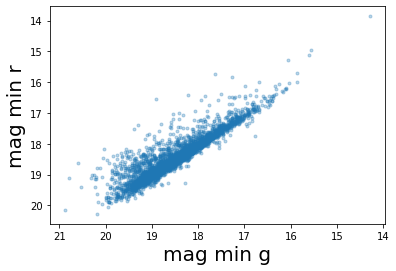

In [67]:
fig, ax = plt.subplots()   
# first, we select the object ids of objects with g band information
oidg = magstats.loc[(magstats.fid == 1)].index
# then, we select objects which are among the previous objects and which have r band information as well
oidgr = magstats.loc[(magstats.fid == 2) & magstats.index.isin(oidg)].index
# now we plot them selecting the g and r bands
ax.scatter(magstats.loc[magstats.fid == 1].loc[oidgr].magmin, magstats.loc[magstats.fid == 2].loc[oidgr].magmin, marker='.', alpha=0.3)
ax.set_xlabel("mag min g", fontsize=20)
ax.set_ylabel("mag min r", fontsize=20)
ax.set_xlim(ax.get_xlim()[::-1])
ax.set_ylim(ax.get_ylim()[::-1])

Another interesting property stored in magstat is the initial rise from the previous detection. This can be used to detect fast rising SNe. Let's plot those objects with large dmdt_first and whose dt_first is not too small (this can lead to divergences).

Text(0.5, 0, 'dm/dt @ first detection')

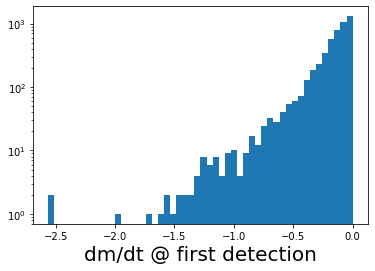

In [68]:
fig, ax = plt.subplots()
ax.hist(magstats.loc[(magstats.dt_first > 0.5) & (magstats.dmdt_first < 0)].dmdt_first, bins=50, log=True);
ax.set_xlabel("dm/dt @ first detection", fontsize=20)

You can see that there are a few objects which rise very fast, let's look at the fastest objects which are very likely SNII, known to rise very fast after due to the prevalence of wind shock breakouts (see e.g. [Förster et al. 2018](https://ui.adsabs.harvard.edu/abs/2018NatAs...2..808F/abstract)):

In [69]:
seloids = magstats.loc[(magstats.dt_first > 0.5) & (magstats.dmdt_first < 0)].index # first get indices sorted by oid
seloids = SNe.loc[SNe.index.isin(seloids) & (SNe.class_name == "SNII") & (SNe.probability > 0.4)].index
seloids = magstats.loc[seloids].sort_values("dmdt_first").index.unique()[:6]
for oid in seloids:
    display(magstats.loc[oid][["dmdt_first", "fid"]])
    alerceonline = "http://alerce.online/object"
    display(HTML("<a href='%s/%s' target=\"_blank\"> %s <a>" % (alerceonline, oid, oid)))

dmdt_first  fid
oid                          
ZTF20aaoldej   -2.561899    1
ZTF20aaoldej   -0.327555    2

dmdt_first  fid
oid                          
ZTF20acmaaan   -0.647407    1
ZTF20acmaaan   -1.953064    2

dmdt_first  fid
oid                          
ZTF21acceboj   -0.869720    1
ZTF21acceboj   -1.732781    2

dmdt_first  fid
oid                          
ZTF21abptxfk   -1.455147    1
ZTF21abptxfk   -1.180088    2

dmdt_first  fid
oid                          
ZTF23aailjjs   -1.357372    1
ZTF23aailjjs   -1.172002    2

dmdt_first  fid
oid                          
ZTF22abcfics   -1.310056    1
ZTF22abcfics   -1.051783    2

Let's generate a link to explore the light curves in the ALeRCE explorer.

In [70]:
suffix = "&count=true&page=1&perPage=1000&sortDesc=true&selectedClassifier=lc_classifier"
url = "https://alerce.online/?" + "&".join("oid=%s" % i for i in magstats.loc[seloids].sort_values("dmdt_first").index) + suffix
print(url)

https://alerce.online/?oid=ZTF20aaoldej&oid=ZTF20acmaaan&oid=ZTF21acceboj&oid=ZTF21abptxfk&oid=ZTF23aailjjs&oid=ZTF22abcfics&oid=ZTF21abptxfk&oid=ZTF23aailjjs&oid=ZTF22abcfics&oid=ZTF21acceboj&oid=ZTF20acmaaan&oid=ZTF20aaoldej&count=true&page=1&perPage=1000&sortDesc=true&selectedClassifier=lc_classifier


You can explore each object and check whether these are very fast rising SNe II. 

## Detection table

Let's query the light curves of objects most likely to be SNe II by accessing the detection table.

~7 s

In [71]:
mask = (SNe_p.ranking.SNII == 1)

query='''
SELECT
    oid, candid, mjd, fid, magpsf, sigmapsf
FROM
    detection
WHERE
    oid in (%s)
''' % ",".join(["'%s'" % oid for oid in SNe_p.loc[mask].index])
all_detections = pd.read_sql_query(query, con=engine)
all_detections.set_index(['candid'], inplace=True)
print(all_detections.shape)
all_detections.head()

/home/fforster/anaconda3/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


(24230, 5)


oid           mjd  fid   magpsf  sigmapsf
candid                                                                
498381456015015001  ZTF18aatyqds  58252.381458    2  18.5149  0.039838
498444120615015116  ZTF18aatyqds  58252.444120    1  18.1934  0.021189
498478916015015004  ZTF18aatyqds  58252.478912    1  18.2436  0.026960
501402876015015005  ZTF18aatyqds  58255.402870    1  17.8810  0.019240
501406600615015097  ZTF18aatyqds  58255.406609    1  17.8328  0.016926

Note that we use groupby to plot the light curves of each SN separated by filter id

Text(0, 0.5, 'mag')

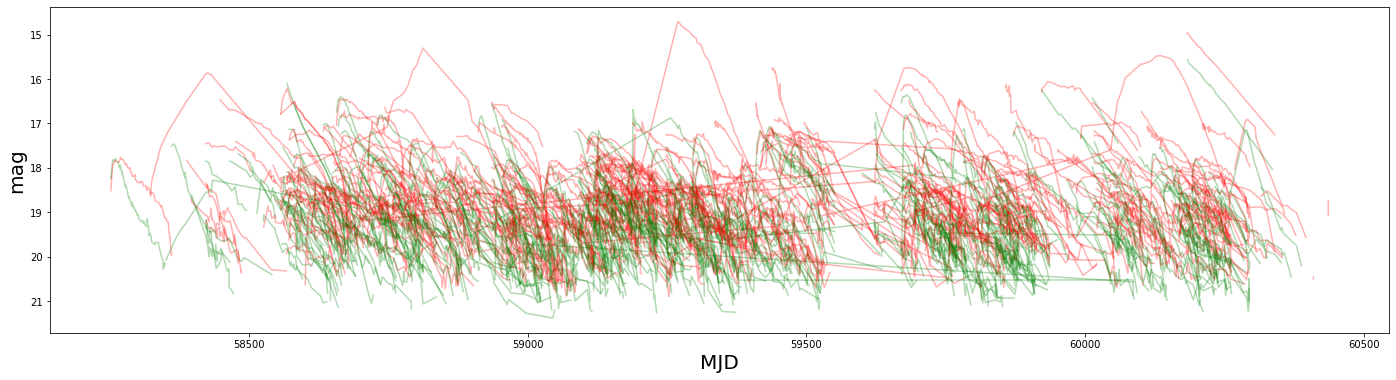

In [72]:
mask = all_detections.oid.isin(SNe_p.loc[(SNe_p.probability.SNII > 0.4)].index)
def plotobject(df):
    df.groupby(["fid"]).apply(
        lambda df: 
        ax.plot(df.mjd, df.magpsf, alpha=0.3, c='g' if df.fid.unique()==1 else 'r'))
fig, ax = plt.subplots(figsize=(24, 6))
all_detections.loc[mask].groupby(["oid"]).apply(plotobject)
ax.set_ylim(ax.get_ylim()[::-1])
ax.set_xlabel("MJD", fontsize=20)
ax.set_ylabel("mag", fontsize=20)

These light curves seem to be OK, with a faster decline in g band followed by a more prominent plateau in r band

We will now compare SNe Ia and SNe Ibc, the two most difficult classes to separate.

Text(0, 0.5, 'SNIbc prob')

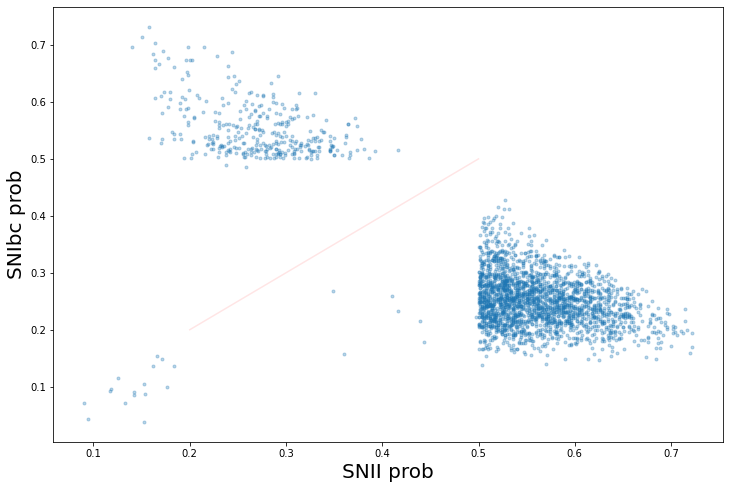

In [73]:
fig, ax = plt.subplots(figsize=(12, 8))
mask = SNe_p.ranking.SNIa.isin([1, 2]) # objects whose first or second most likely class is SNe II

ax.scatter(SNe_p.loc[mask].probability.SNIa, SNe_p.loc[mask].probability.SNIbc, marker='.', alpha=0.3)
ax.plot([0.2, 0.5], [0.2, 0.5], c='r', alpha=0.1)
ax.set_xlabel("SNII prob", fontsize=20)
ax.set_ylabel("SNIbc prob", fontsize=20)

Now we will show the histograms of light curve durations of those SNe more likely to be SNe Ia or SNe Ibc. Since SNe Ibc progenitors tend to be more massive at explosion they should have slightly longer light curves.

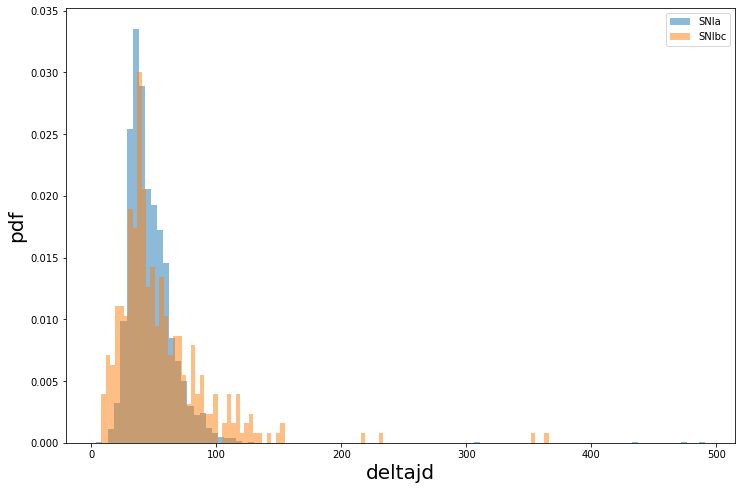

In [74]:
fig, ax = plt.subplots(figsize=(12, 8))
for idx, sn in enumerate(["SNIa", "SNIbc"]):
    mask = (SNe_p.ranking[sn] == 1)
    ax.hist(SNe.loc[mask].deltajd, bins=100, label=sn, alpha=0.5, density=True)
ax.set_xlabel("deltajd", fontsize=20)
ax.set_ylabel("pdf", fontsize=20)
ax.legend()        

We confirm that SNe Ibc light curves are slightly longer, although there are some very long SNe Ibc and some very short SNe Ibc, probably misclassifications.
Another expected difference is that SNe Ibc are redder at maximum. Let's compare their colors.

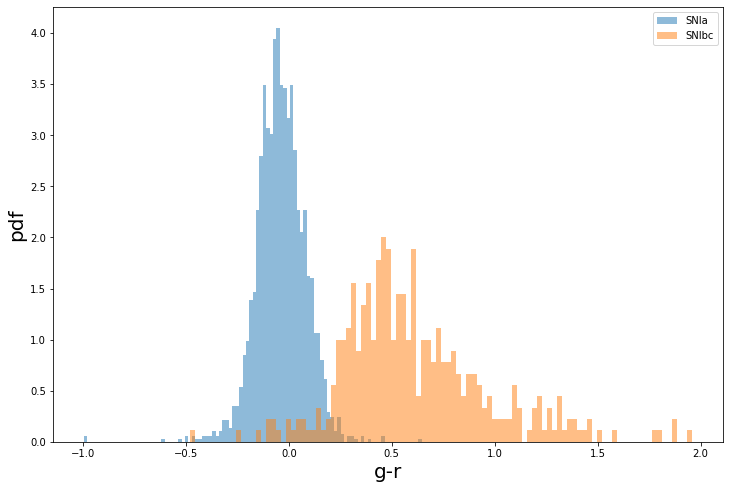

In [76]:
fig, ax = plt.subplots(figsize=(12, 8))
for idx, sn in enumerate(["SNIa", "SNIbc"]):
    mask = (SNe_p.ranking[sn] == 1)
    ax.hist(SNe_p.loc[mask].g_r_max[sn].dropna(), bins=100, label=sn, alpha=0.5, density=True)
ax.set_xlabel("g-r", fontsize=20)
ax.set_ylabel("pdf", fontsize=20)
ax.legend()        

We confirm that SNe Ibc g-r colors are redder at maximum.

## PS1 table
Let's get some proxy for host galaxy information based on the closest PanSTARRS source. There are more advanced, but slower methods methods to get the host, e.g. https://pypi.org/project/astro-delight/.

~5 s

In [77]:
query='''
SELECT
    oid, sgmag1, srmag1, simag1, szmag1, sgscore1
FROM
    ps1_ztf
WHERE
    oid in (%s)
''' % ",".join(["'%s'" % oid for oid in SNe_p.index.unique()])
ps1 = pd.read_sql_query(query, con=engine)
ps1.set_index("oid", inplace=True)
ps1.head()

/home/fforster/anaconda3/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


sgmag1    srmag1    simag1    szmag1  sgscore1
oid                                                          
ZTF17aaahhwn  21.1560 -999.0000 -999.0000 -999.0000  0.500000
ZTF18aadaexi  18.3167   17.4377   17.0905   16.8439  0.036125
ZTF18aadlaxo  17.8747   17.2470   16.8267   16.3905  0.075905
ZTF18aadvwyz  18.9006   17.9969   17.4920   17.2798  0.028750
ZTF18aadzfso  18.3342   17.6568   17.1183   16.9610  0.024792

In [78]:
ps1["g_r_host"] = ps1.sgmag1 - ps1.srmag1
ps1["r_i_host"] = ps1.srmag1 - ps1.simag1
ps1["sgscore1"] = ps1.sgscore1

We make a cut on galaxy classified sources, non zero colors, and relatively small absolute values. We plot their cumulative distributions and do KS tests.

Text(0.5, 0, 'Host r-i')

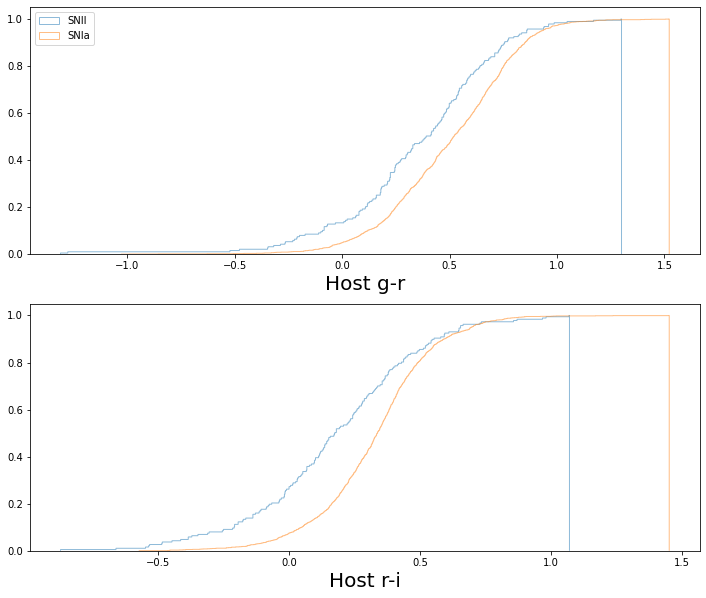

In [79]:
from scipy import stats
fig, ax = plt.subplots(nrows=2, figsize=(12, 10))
mask_host = (ps1.sgscore1 < 0.5) & (ps1.g_r_host.abs() > 0) & (ps1.g_r_host.abs() < 2) & (ps1.r_i_host.abs() > 0) & (ps1.r_i_host.abs() < 2)
for sn in ["SNII", "SNIa"]:
    oid_sn = SNe_p.loc[SNe_p.ranking[sn] == 1].index
    mask = mask_host & ps1.index.isin(oid_sn)
    oid = ps1.loc[mask].index
    ax[0].hist(ps1.loc[mask].g_r_host, label=sn, bins=1000, alpha=0.5, cumulative=True, density=True, histtype='step')
    ax[1].hist(ps1.loc[mask].r_i_host, label=sn, bins=1000, alpha=0.5, cumulative=True, density=True, histtype='step')
ax[0].legend()
ax[0].set_xlabel("Host g-r", fontsize=20)
ax[1].set_xlabel("Host r-i", fontsize=20)

We can see that SNe Ia tend to live in redder galaxies than SNe II, which is consistent with them being associated to older progenitors.

We will now query and plot the light cuves of 2000 SNe taken randomly from the previous samples.

~5 s

In [80]:
mask = SNe.class_name.isin(["SNIa", "SNIbc", "SNII", "SLSN"]) & (SNe.ranking == 1)
# using SNe_p would be mask = (SNe_p.ranking.SNIa == 1) | (SNe_p.ranking.SNIbc == 1) | (SNe_p.ranking.SNII == 1) | (SNe_p.ranking.SLSN == 1)
query='''
SELECT
    oid, candid, mjd, fid, magpsf, sigmapsf
FROM
    detection
WHERE
    oid in (%s)
''' % ",".join(["'%s'" % oid for oid in SNe.loc[mask].iloc[:2000].index])
all_detections = pd.read_sql_query(query, con=engine)
all_detections.set_index(['candid'], inplace=True)
all_detections.head()

/home/fforster/anaconda3/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


oid           mjd  fid     magpsf  sigmapsf
candid                                                                   
1497264455315015019  ZTF18aadlaxo  59251.264456    1  20.099700  0.282125
1499237585315015007  ZTF18aadlaxo  59253.237581    1  19.499796  0.133110
1503223555315015012  ZTF18aadlaxo  59257.223553    2  18.546896  0.075005
1503340045315015012  ZTF18aadlaxo  59257.340046    1  18.513515  0.132465
1508223955315015005  ZTF18aadlaxo  59262.223958    2  18.262700  0.091816

We will plot objects with a probability of being SNe Ia larger than 0.4

Text(0, 0.5, 'mag')

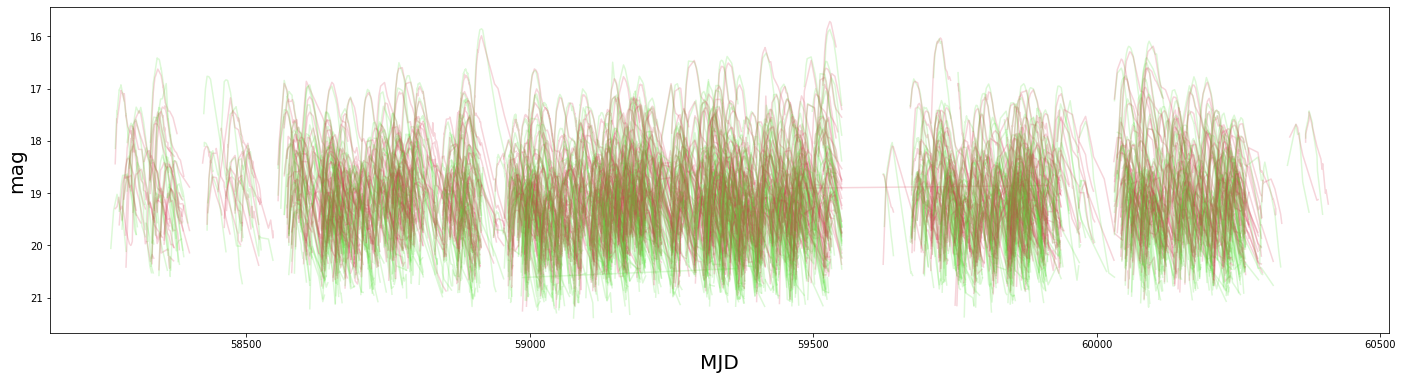

In [81]:
mask = (SNe_p.ranking.SNIa == 1) & (SNe_p.probability.SNIa > 0.4)
mask = all_detections.oid.isin(SNe_p.loc[mask].index)
def plotobject(df):
    df.groupby(["fid"]).apply(
        lambda df: 
        ax.plot(df.mjd, df.magpsf, alpha=0.2, c=colors[1] if df.fid.unique()==1 else colors[2]))
fig, ax = plt.subplots(figsize=(24, 6))
all_detections.loc[mask].groupby(["oid"]).apply(plotobject)
ax.set_ylim(ax.get_ylim()[::-1])
ax.set_xlabel("MJD", fontsize=20)
ax.set_ylabel("mag", fontsize=20)

Here we can see that most SN light curves look OK, although there a few which seem to be too long.

## Feature table

A family of features we compute for all objects is provided by a simple analytic SN light curve, a reparametrization of the model of [Villar et al. 2019](https://ui.adsabs.harvard.edu/abs/2019ApJ...884...83V/abstract et al. 2019) (see Sánchez-Sáez et al. 2020).

This model is the following:

$$
\Large
F = \begin{cases}
        \cfrac{A \left(1 - \beta' \frac{t - t_0}{t_1 - t_0}\right)}{1 + \exp{\left(-\frac{t - t_0}{\tau_{\rm rise}}\right)}} & \mbox{if} \; t < t_1  \\ 
        \\
        \cfrac{A (1 - \beta') \exp{\left(-\frac{t - t_1}{\tau_{\rm fall}}\right)}}{1 + \exp{\left(-\frac{t - t_0}{\tau_{\rm rise}}\right)}} & \mbox{if} \; t \ge t_1,
  \end{cases}
$$

where we measure $t_0$ w.r.t. the first dectection. We will overplot the best fitting models to get an idea of how good these fits are.

Let's query the feature names from the `feature` table to see what is available. Note that this table is similar to probabilities, where there is a `name` column which refers to a given feature and where its value and associated fid are stored in different columns.

These features start with SPM (supernova parametric models), so we will look for features starting with these three characters. For this query we will again use the SNe dataframe.

In [82]:
mask = SNe.class_name.isin(["SNIa", "SNIbc", "SNII", "SLSN"]) & (SNe.ranking == 1)
query='''
SELECT
    *
FROM
    feature
WHERE
    LEFT(name, 3)='SPM'
    AND oid in (%s)
''' % ",".join(["'%s'" % oid for oid in SNe.loc[mask].iloc[:2000].index])
features = pd.read_sql_query(query, con=engine)
features.head()

/home/fforster/anaconda3/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


oid          name      value  fid                version
0  ZTF18aadlaxo         SPM_A   0.179493    1  lc_classifier_1.2.1-P
1  ZTF18aadlaxo        SPM_t0   3.770486    1  lc_classifier_1.2.1-P
2  ZTF18aadlaxo     SPM_gamma  12.565474    1  lc_classifier_1.2.1-P
3  ZTF18aadlaxo      SPM_beta   0.044362    1  lc_classifier_1.2.1-P
4  ZTF18aadlaxo  SPM_tau_rise   2.346088    1  lc_classifier_1.2.1-P

Let's display the unique feature names

In [83]:
features.name.unique()

array(['SPM_A', 'SPM_t0', 'SPM_gamma', 'SPM_beta', 'SPM_tau_rise',
       'SPM_tau_fall', 'SPM_chi'], dtype=object)

You can see that each object has one row per feature per band. Let's create a pivoted view similar to what we did with the probabilitiues dataframe. We will first create an auxiliary column to use as pivot to make the pivot unique per object.

In [84]:
features["name_fid"] = features["name"] + "_" + features.fid.astype(str)

And now we can use this column as pivot:

In [85]:
features_p = features.pivot_table(columns="name_fid", values="value", index="oid")
features_p.head()

name_fid       SPM_A_1   SPM_A_2  SPM_beta_1  SPM_beta_2  SPM_chi_1  \
oid                                                                   
ZTF18aadlaxo  0.179493  0.277442    0.044362     0.00000   0.108782   
ZTF18aadvwyz  0.105397  0.086135    0.011775     0.00000   0.129665   
ZTF18aaflyqi  0.387860  0.261045    0.079417     0.00000   0.062142   
ZTF18aafzers  0.291695  0.251731    0.487170     0.63004   0.340629   
ZTF18aajjhkq  0.209809  0.197371    0.764688     0.50679   0.029772   

name_fid      SPM_chi_2  SPM_gamma_1  SPM_gamma_2  SPM_t0_1  SPM_t0_2  \
oid                                                                     
ZTF18aadlaxo   0.053051    12.565474     5.449469  3.770486  0.836442   
ZTF18aadvwyz   0.094009     3.962066     4.732027  5.079967 -1.867520   
ZTF18aaflyqi   0.188178     9.726987    15.809203  0.554673  1.164479   
ZTF18aafzers   0.683950    14.690306    30.135403  4.946149  4.096559   
ZTF18aajjhkq   0.106438    29.068941    20.720608  3.893923  5.037555   

name_fid      SPM_tau_fall_1  SPM_tau_fall_2  SPM_tau_rise_1  SPM_tau_rise_2  
oid                                                                           
ZTF18aadlaxo        7.538693       15.008492        2.346088        7.668249  
ZTF18aadvwyz       11.563021       29.068291        3.613637        2.610047  
ZTF18aaflyqi       13.051220       18.744401        5.090340        2.430250  
ZTF18aafzers        7.958878       17.999070        2.449585        2.311448  
ZTF18aajjhkq       17.835082       50.059244        2.526241        3.851998

Let's define a function and test it with one SN

In [86]:
def Villar_m(mjd, firstmjd, pars):
    A = pars["SPM_A"] # * 1e-26 # erg/s/Hz, note that we save 1e26 * A in cgs in the database
    t0 = pars["SPM_t0"]
    beta_m = pars["SPM_beta"]
    gamma = pars["SPM_gamma"]
    trise = pars["SPM_tau_rise"]
    tfall = pars["SPM_tau_fall"]
    
    # correct t0 and t1
    mjd0 = t0 + firstmjd
    mjd1 = mjd0 + gamma
    
    # mask
    mask = mjd < mjd1

    F = np.zeros_like(mjd)
    if mask.sum() > 0:
        den = (1. + np.exp(-(mjd[mask] - mjd0) / trise))
        F[mask] = A * (1 - beta_m * (mjd[mask] - mjd0) / (mjd1 - mjd0)) / den
    if np.invert(mask).sum() > 0:
        den = (1. + np.exp(-(mjd[~mask] - mjd0) / trise))
        F[~mask] = A * ((1 - beta_m) * np.exp(-(mjd[~mask] - mjd1) / tfall)) / den
    
    return F

Let's define a function to transform fluxes into magnitudes

In [87]:
def flux2mag(flux):
    return -2.5 * np.log10(flux) + 2.5 * 26 - 48.6 # note that the factor 2.5 * 26 comes from the fact that the normalization is stored multiplied by 1e26, to take less space in our database

Now we will plot the model light curves for all the objects with probability of being SN Ia greater than 0.4

~19 s

(22.0, 15.0)

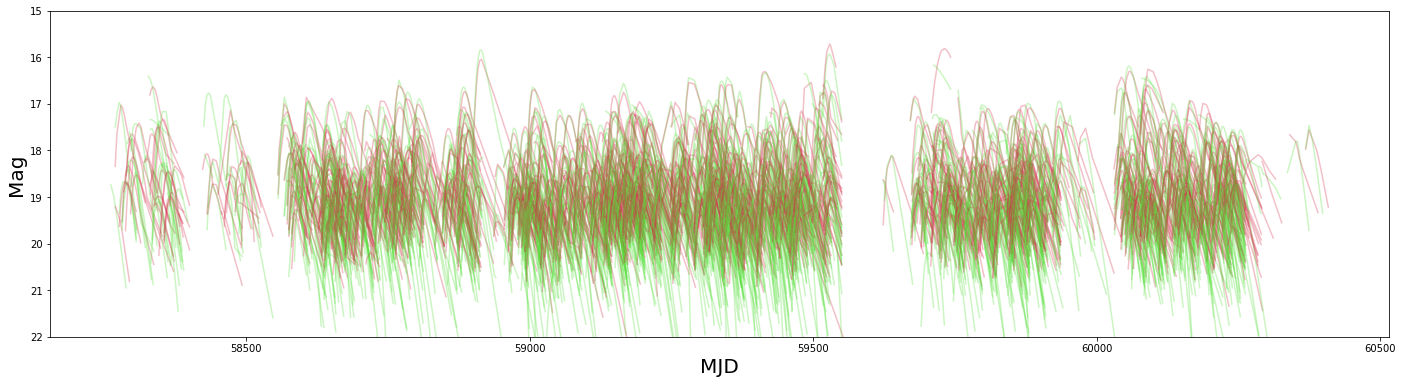

In [88]:
fig, ax = plt.subplots(figsize=(24, 6))
oids = SNe_p.loc[(SNe_p.probability.SNIa > 0.4) & (SNe_p.ranking.SNIa == 1)].index
for oid in oids:
    mask_det = all_detections.oid == oid
    for fid in all_detections.loc[mask_det].fid.unique():
        if fid == 3:
            continue
        mask_fid = all_detections.loc[mask_det].fid == fid
        times = all_detections.loc[mask_det].loc[mask_fid].mjd.values
        magpsf = all_detections.loc[mask_det].loc[mask_fid].magpsf.values
        vals = {}
        for val in features.name.unique(): # loop among the unique feature names
            vals[val] = features_p.loc[oid]["%s_%s" % (val, fid)]
        model = Villar_m(times, SNe.loc[oid].firstmjd.iloc[0], vals)
        mask = model > 0
        ax.plot(times[mask], flux2mag(model[mask]), c=colors[fid], alpha=0.3)
    #break

ax.set_ylabel("Mag", fontsize=20)
ax.set_xlabel("MJD", fontsize=20)
ax.set_ylim(22, 15)

The modeled light curves look OK (compare to our previous plot of observed light curves)

And now the SNe II candidates with probabilities greater than 0.3

(22.0, 15.0)

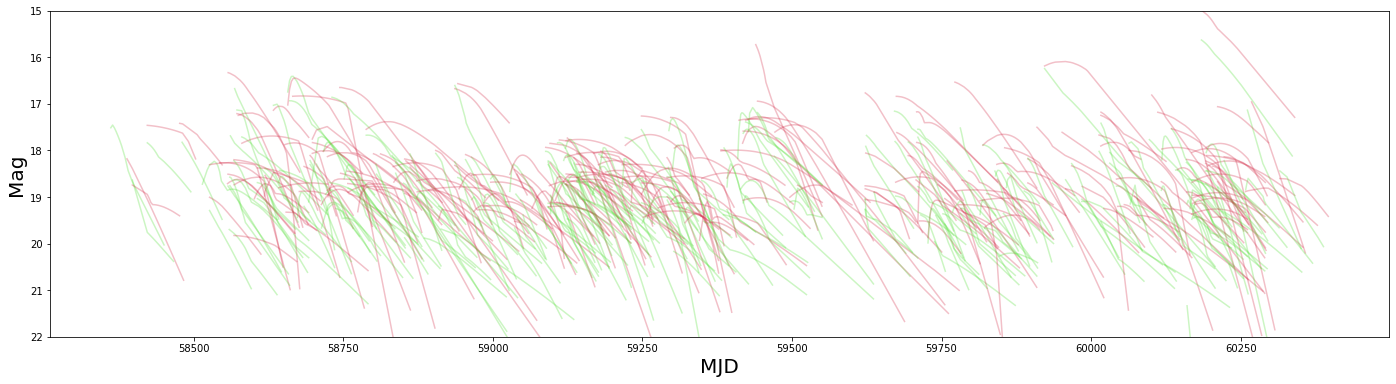

In [89]:
fig, ax = plt.subplots(figsize=(24, 6))
oids = SNe_p.loc[(SNe_p.probability.SNII > 0.3) & (SNe_p.ranking.SNII == 1)].index
for oid in oids:
    mask_det = all_detections.oid == oid
    for fid in all_detections.loc[mask_det].fid.unique():
        if fid == 3:
            continue
        mask_fid = all_detections.loc[mask_det].fid == fid
        times = all_detections.loc[mask_det].loc[mask_fid].mjd.values
        magpsf = all_detections.loc[mask_det].loc[mask_fid].magpsf.values
        vals = {}
        for val in features.name.unique(): # loop among the unique features
            vals[val] = features_p.loc[oid]["%s_%s" % (val, fid)]
        model = Villar_m(times, SNe.loc[oid].firstmjd.iloc[0], vals)
        mask = model > 0
        ax.plot(times[mask], flux2mag(model[mask]), c=colors[fid], alpha=0.3)
    #break

ax.set_ylabel("Mag", fontsize=20)
ax.set_xlabel("MJD", fontsize=20)
ax.set_ylim(22, 15)

The light curves look longer lived, although it's difficult to see the plateau. Let's compare their beta and gamma parameters.

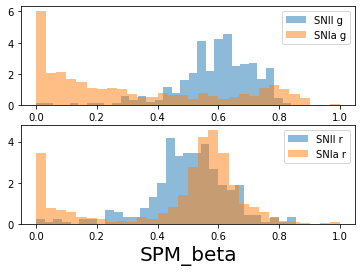

In [90]:
fig, ax = plt.subplots(nrows = 2)
labels = {1: 'g', 2: 'r'}
for idx, fid in enumerate([1, 2]):
    mask_feat = (features.fid == fid) & (features.name=="SPM_beta") & features.oid.isin(SNe_p.loc[SNe_p.probability.SNII > 0.3].index)
    ax[idx].hist(features.loc[mask_feat].dropna().value, label="SNII %s" % labels[fid], alpha=0.5, bins=30, density=True);
    mask_feat = (features.fid == fid) & (features.name=="SPM_beta") & features.oid.isin(SNe_p.loc[SNe_p.probability.SNIa > 0.4].index)
    ax[idx].hist(features.loc[mask_feat].dropna().value, label="SNIa %s" % labels[fid], alpha=0.5, bins=30, density=True);
    ax[idx].legend()
    ax[idx].set_xlabel("SPM_beta", fontsize=20)

Beta values are dimensionless and move between 0 and 1. SNe II tend to have smaller beta values in the g band, while SNe Ia don't have small beta values in either band.

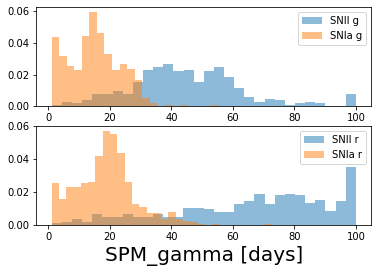

In [92]:
fig, ax = plt.subplots(nrows = 2)
labels = {1: 'g', 2: 'r'}
for idx, fid in enumerate([1, 2]):
    mask_feat = (features.fid == fid) & (features.name=="SPM_gamma") & features.oid.isin(SNe_p.loc[SNe_p.probability.SNII > 0.3].index)
    ax[idx].hist(features.loc[mask_feat].dropna().value, label="SNII %s" % labels[fid], alpha=0.5, bins=30, density=True);
    mask_feat = (features.fid == fid) & (features.name=="SPM_gamma") & features.oid.isin(SNe_p.loc[SNe_p.probability.SNIa > 0.4].index)
    ax[idx].hist(features.loc[mask_feat].dropna().value, label="SNIa %s" % labels[fid], alpha=0.5, bins=30, density=True);
    ax[idx].legend()
    ax[idx].set_xlabel("SPM_gamma [days]", fontsize=20) 

We can see that gamma values are in general larger for SNe II for the g and r bands, as expected.

## Non_detection table

Finally, here we show how to get all the non detections associated to the previous sample, selecting only limiting magnitude above 17 magnitudes (~22 s).

In [94]:
query = '''
SELECT
    oid, fid, diffmaglim, mjd
FROM
    non_detection
WHERE
    diffmaglim > 17
    AND oid in (%s)
''' % ",".join(["'%s'" % oid for oid in SNe.loc[(SNe.class_name == "SNIa") & (SNe.ranking == 1)].sample(1000).index.unique()])
all_non_detections = pd.read_sql_query(query, con=engine)
all_non_detections.head()

/home/fforster/anaconda3/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


oid  fid  diffmaglim           mjd
0  ZTF18aadaexi    1     20.6492  59248.257454
1  ZTF18aadaexi    1     20.3865  59250.261424
2  ZTF18aadaexi    1     20.8138  59252.263958
3  ZTF18aadaexi    1     20.8714  59254.223160
4  ZTF18aadaexi    1     20.8665  59256.297743

And we show the distribution of limiting magnitudes

Text(0.5, 0, 'Limiting magnitude')

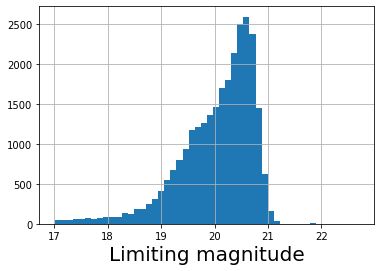

In [95]:
fig, ax = plt.subplots()
all_non_detections.diffmaglim.hist(bins=50, ax=ax)
ax.set_xlabel("Limiting magnitude", fontsize=20)

Let's compute the moon phase at all time for the non detections

In [96]:
from astropy.time import Time

A reference time for a new moon

In [97]:
new_moon = Time("2020-07-20T13:32:00", format='isot', scale='utc')

The synodic moon period

In [98]:
moon_synodic_period = 29.53049

Apply a function which returns the moon phase (

In [99]:
all_non_detections["moon_phase"] = all_non_detections.apply(lambda row: np.mod((Time(row.mjd, format='mjd') - new_moon).value, moon_synodic_period) / moon_synodic_period, axis=1)

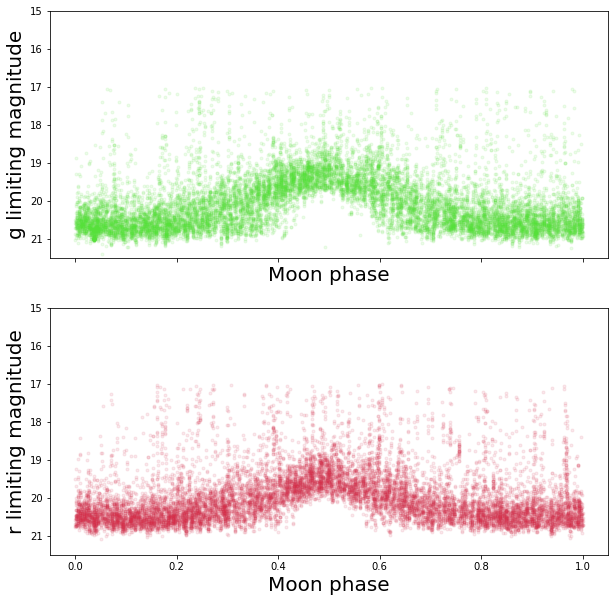

In [100]:
fig, ax = plt.subplots(nrows = 2, figsize = (10, 10), sharex = True)
for idx, fid in enumerate(all_non_detections.fid.unique()):
    if fid == 3:
        continue
    mask = all_non_detections.fid == fid
    ax[idx].scatter(all_non_detections.moon_phase.loc[mask], all_non_detections.diffmaglim.loc[mask],
                    c=colors[fid], marker='.', alpha=0.1)
    ax[idx].set_ylim(21.5, 15)
    ax[idx].set_xlabel("Moon phase", fontsize=20)
    c = 'g' if fid == 1 else 'r'
    ax[idx].set_ylabel("%s limiting magnitude" % c, fontsize=20)

We can see that, as expected, limiting magnitudes are smaller close to full moon. There is a about 1.5 and 1.0 magnitudes of difference in depth between the new and full moon in the g and r bands, respectively.

**Congratulations, you made it to the end of this notebook!**

**If you would like to contribute with your own notebook, please let us know!**